# Volatility Prediction

변동성은 리스크를 나타내는 가장 중요한 척도 중 하나로 1996년 바젤 협정 이후 위험 관리에서 핵심적인 역할을 하고 있다. 변동성을 모델링하는 것은 불확실성과 리스크를 모델링 하는 것이다. 변동성을 모델링하는 가장 기초적인 방법은 실현 변동성을 계산하는 것이다. 실현 변동성은 다음과 같은 공식을 통해 도출된다.

$$\sigma=\sqrt{\frac{1}{n-1}\Sigma_{n=1}^N(r_n-\mu)^2}$$

여기서 $\mu$는 평균 수익률, $n$은 관측치의 수를 나타낸다.

다음 코드는 파이썬을 통해 실현 변동성을 계산하는 코드이다.

In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [3]:
ret = 100 * (s_p500.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()  # rolling 평균을 구한 뒤 이에 대한 표준편차 계산

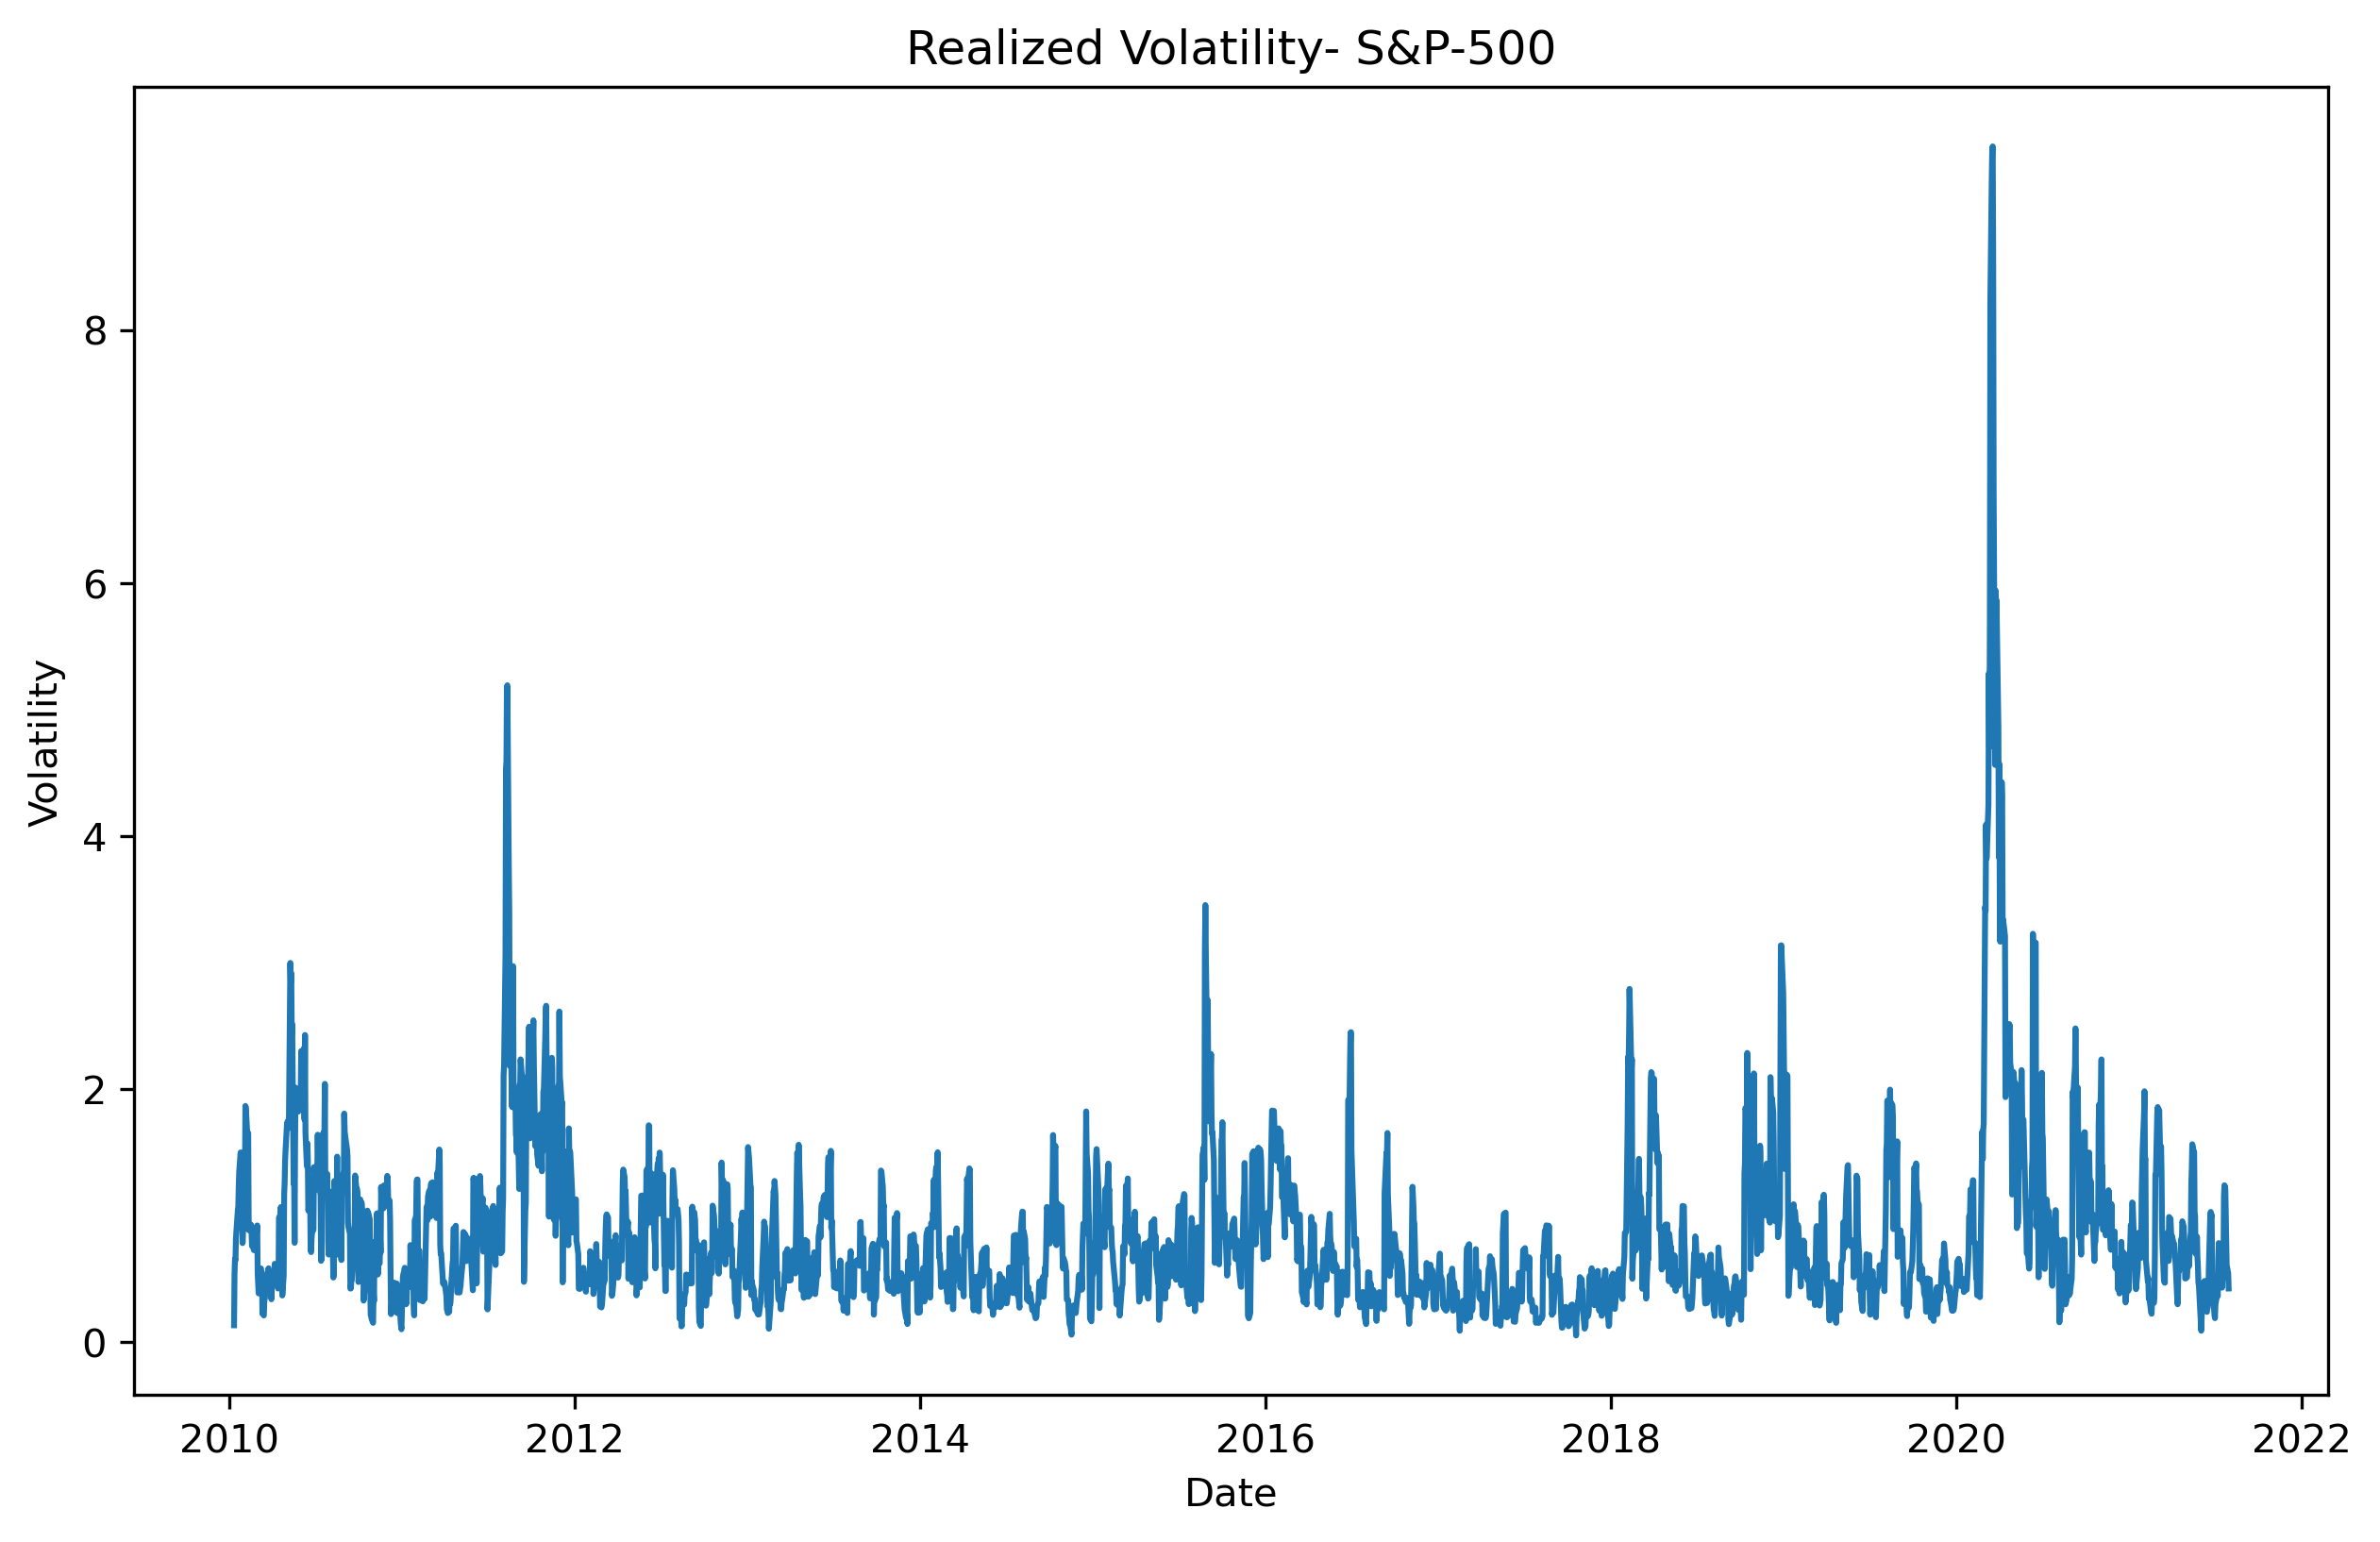

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500') 
plt.ylabel('Volatility')
plt.xlabel('Date') 
plt.show()

변동성을 추정하는 고전적 변동성 모델에는 다음과 같은 모델들이 존재한다.

- ARCH
- GARCH
- GJR-GARCH
- EGARCH

## 조건부 변동성 모형

변동성 모형을 적절한 관점에서 설명하기 위해서는 $F_{t-1}$이 주어진 $r_t$의 조건부 평균과 분산을 고려하는 것이 유익하다

$$μ_t = E(r_t|F_{t−1}), σ_t^2 = \mathrm{Var}(r_t|F_{t−1})=E[(r_t −μ_t)^2|F_{t−1}]$$

여기서 $F_{t-1}$이란 $t-1$시기에 가용가능한 모든 정보의 집합이다. 여기서 얻을 수 있는 정보에는 정보의 비대칭성이나 비효율성이 고려되지 않는다.
$\mathrm{ARCH}$ 모형 추정을 위해 $r_t$가 일부 설명 변수가 있는 안정적인 $\mathrm{ARMA}(p,q)$모형과 같은 간단한 시계열 모형을 따른다고 가정한다

$$r_t = μ_t + a_t, ~~~~~ μ_t = \sum_{i=1}^p \phi_i y_{t-i} + a_t - \sum_{i=1}^q \theta_i a_{t-i}, ~~~~~ y_t = r_t - \phi_0 - \sum_{i=1}^k β_i x_{it}$$

여기서 $y_t$는 단순히 설명 변수의 효과를 제거한 후의 조정된 임의의 time series를 나타낸다. 위 두개의 식에 의해

$$\sigma_t^2 = \mathrm{Var}(r_t|F_{t-1}) = \mathrm{Var}(a_t |F_{t-1})$$

임을 보일 수 있다. 이런 조건부 변동성 모형은 변동성 군집화 현상을 모델링 할 수 있다.


다음은 실제 변동성 군집화 현상을 보여주는 예시이다.

In [5]:
retv = ret.values

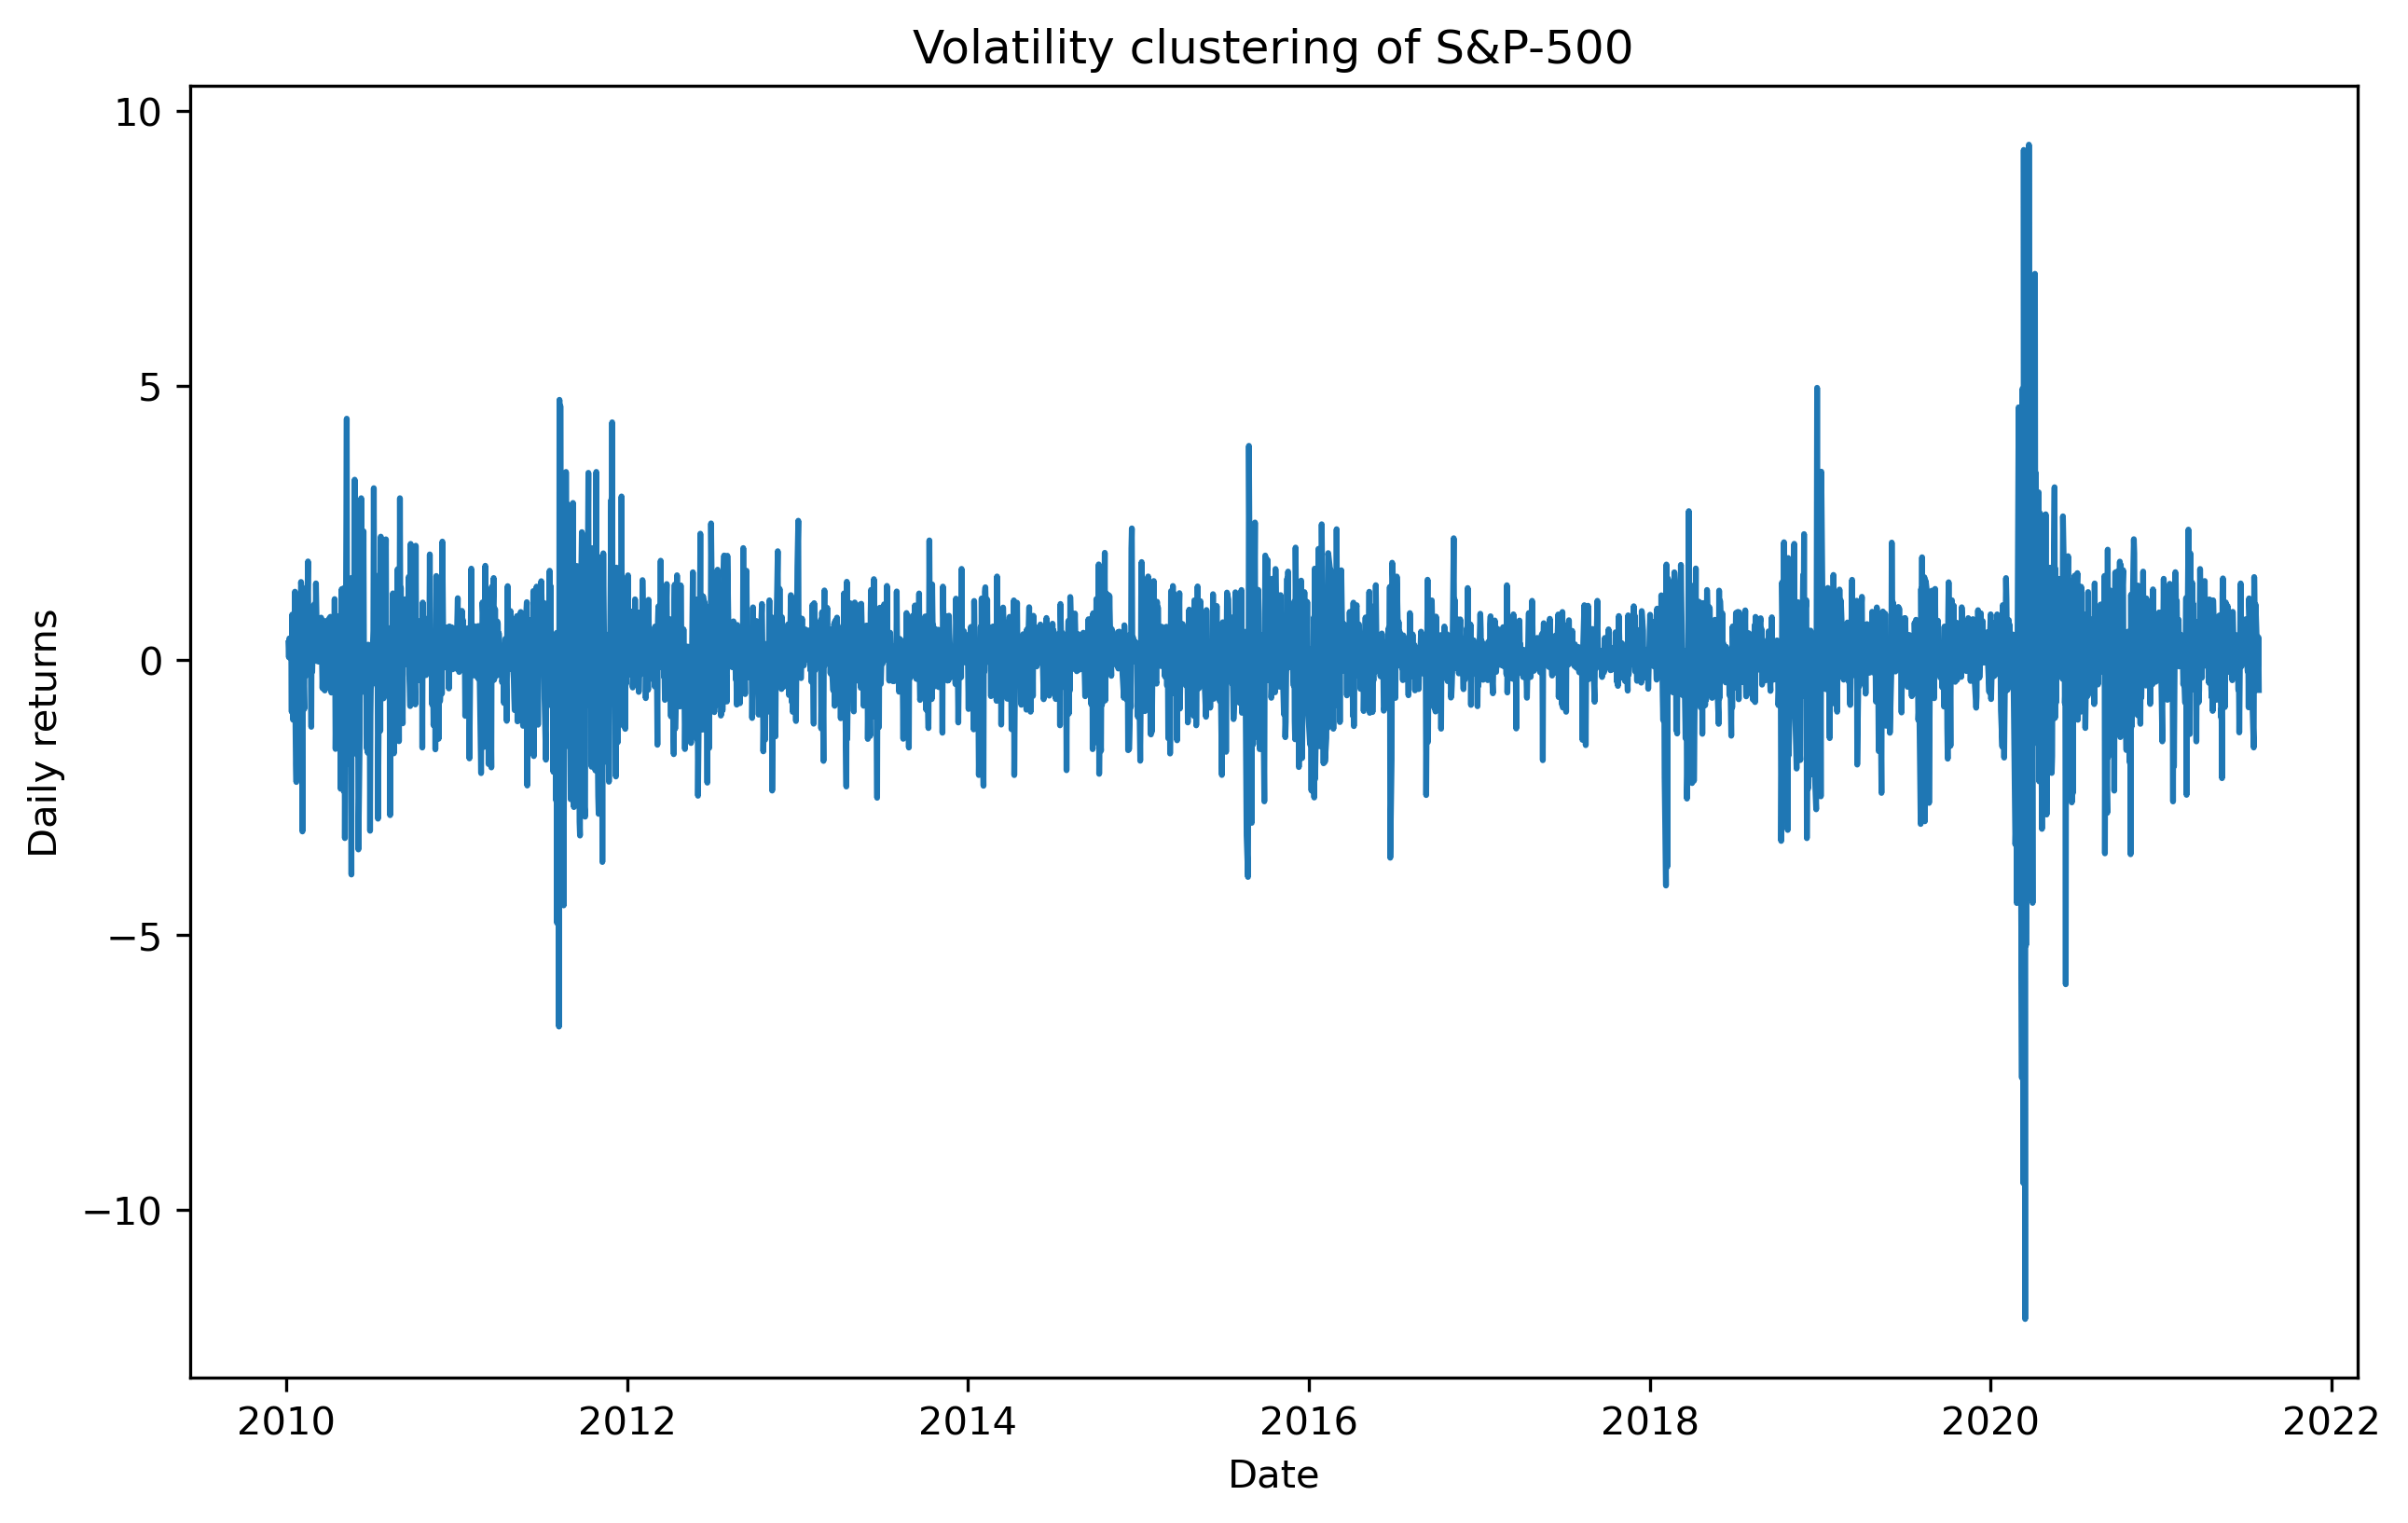

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500') 
plt.ylabel('Daily returns')
plt.xlabel('Date') 
plt.show()

## ARCH

$\mathrm{ARCH}$ 모형은 다음과 같이 추정된다

$$a_t = \sigma_t \epsilon_t, ~~~~~ \sigma_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + \cdots + \alpha_ma_{t-m}^2$$

여기서 $\{\epsilon_t\}$는 평균이 0이고 분산이 1인 IID random variables sequence이다$(i>0$일 때, $\alpha_0 > 0, \alpha_i \geq 0)$. 위 모형을 해석하면, 현재의 충격은 이전의 충격들의 영향으로 이뤄진 것이다. 즉, 변동성의 군집현상을 어느정도 설명하려고 한 시도로 보인다. $\mathrm{ARCH}$ 모형을 이해하기 위해서는 우선 $\mathrm{ARCH}(1)$ 모형을 알아봐야 한다

$$a_t = \sigma_t \epsilon_t,~~~~~ \sigma_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2$$

여기서 $\alpha_0 > 0, \alpha_1 \geq 0$이다. 우선, $a_t$의 unconditional mean을 0으로 만든다

$$E(a_t) = E[E(a_t|F_{t-1})] = E[\sigma_t E(\epsilon_t)] = 0$$

$a_t$의 unconditional variance는 다음과 같이 구할 수 있다

$$\mathrm{Var}(a_t) = E(a_t^2) = E[E(a_t^2|F_{t-1})] = E(\alpha_0 + \alpha_1 a_{t-1}^2) = \alpha_0 + \alpha_1 E(a_{t-1}^2)$$

$a_t$는 stationart process이고 $E(a_t) = 0, \mathrm{Var}(a_t) = \mathrm{Var}(a_{t-1}) = E(a_{t-1}^2)$이므로, $\mathrm{Var}(a_t) = \alpha_0 + \alpha_1\mathrm{Var}(a_t)$이며 $\mathrm{Var}(a_t) = \frac{\alpha_0}{1-\alpha_1}$이다. $a_t$의 분산은 양수여야 하기 떄문에, $0 \leq \alpha_1 < 1$이어야만 한다.

$\mathrm{ARCH}$ 모형은 조건부 변동성 모형으로 변동성 군집화 현상을 모델링 할 수 있다.

하지만 $\mathrm{ARCH}$ 에는 단점 또한 존재한다. $\mathrm{ARCH}$ 모형의 가장 큰 단점 네 가지는 다음과 같다

1. 음의 방향 충격과 양의 방향의 충격을 잔차를 제곱함으로써 같은 것으로 간주한다. 그러나 실증적으로는 음의방향과 양의 방향의 충격의 크기가 다른 것으로 나타난다
2. $\mathrm{ARCH}$ 모형은 제약이 너무 크다. 한 예로, $\mathrm{ARCH}(1)$ 모형의 $\sigma_1^2$는 닫힌구간 $[0, \frac{1}{3}]$에 있어야 한다. 실증적으로는, 이러한 가정이 지켜지지 않는 경우가 많다
3. $\mathrm{ARCH}$ 모형은 새로운 insight를 얻을 수 없다. 단지 변동의 형태를 기술하는 방법을 제공할 뿐, 무엇이 변동성을 불러 일으키는지는 알 수 없다
4. $\mathrm{ARCH}$ 모형은 종종 변동성을 과도하게 추정할 위험이 존재한다

In [7]:
n = 252
split_date = ret.iloc[-n:].index

In [8]:
sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 * 
                             (3.0 * sgm2 - K) * K)) / (6 * K)
omega = (1 - alpha) * sgm2
initial_parameters = [alpha, omega]
omega, alpha

(0.634156491639156, 0.46673132307801635)

ARCH 모델의 추정은 최대 우도 추정 방법을 이용한다. 우도 함수로 정규분포를 가정했을때 최대우도추정치 유도는 다음과 같다(그림의 최대우도추정법은 GARCH 모델에 대해 작성하였음에 유의하라)

<center>
    
<img src="./Image/최대우도추정법.png" width="700px" height="400px">
    
</center>

In [9]:
@jit(nopython=True, parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2))
    return logliks


In [10]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

1451.5757030518016

In [11]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args = (retv),
                              method='Nelder-Mead', 
                              options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'
          .format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

In [12]:
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization
----------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1384.4549035108566
             x: [ 7.015e-01  3.913e-01]
           nit: 30
          nfev: 58
 final_simplex: (array([[ 7.015e-01,  3.913e-01],
                       [ 7.016e-01,  3.913e-01],
                       [ 7.016e-01,  3.914e-01]]), array([ 1.384e+03,  1.384e+03,  1.384e+03]))

Resulting params = [0.70152949 0.39126701]


In [13]:
def arch_apply(ret):
        omega = params[0]
        alpha = params[1]
        T = len(ret)
        sigma2_arch = np.zeros(T + 1)
        sigma2_arch[0] = np.var(ret)
        for t in range(1, T):
            sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
        return sigma2_arch

In [14]:
sigma2_arch = arch_apply(ret)

다음 코드는 파이썬 내장코드를 이용해 ARCH 모델을 추정하는 과정이다

In [15]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4061.27
Distribution:                  Normal   AIC:                           8126.54
Method:            Maximum Likelihood   BIC:                           8138.50
                                        No. Observations:                 2913
Date:                Fri, Oct 18 2024   Df Residuals:                     2913
Time:                        17:11:33   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7014  5.002e-02     14.023  1.129e-44 [  0.603,  0.79

다음은 ARCH 모델의 차수를 결정하기 위해 BIC score를 바탕으로 1부터 5까지 BIC를 최소화하는 차수를 찾는 과정이다

In [16]:
bic_arch = []

for p in range(1, 5):
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
                .fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
        .fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3709.51
Distribution:                  Normal   AIC:                           7429.03
Method:            Maximum Likelihood   BIC:                           7458.91
                                        No. Observations:                 2913
Date:                Fri, Oct 18 2024   Df Residuals:                     2913
Time:                        17:11:33   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2794  2.580e-02     10.829  2.498e-27   [  0.22

In [17]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, 
                        np.sqrt(forecast_arch\
                        .variance.iloc[-len(split_date):] 
                        / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.0896


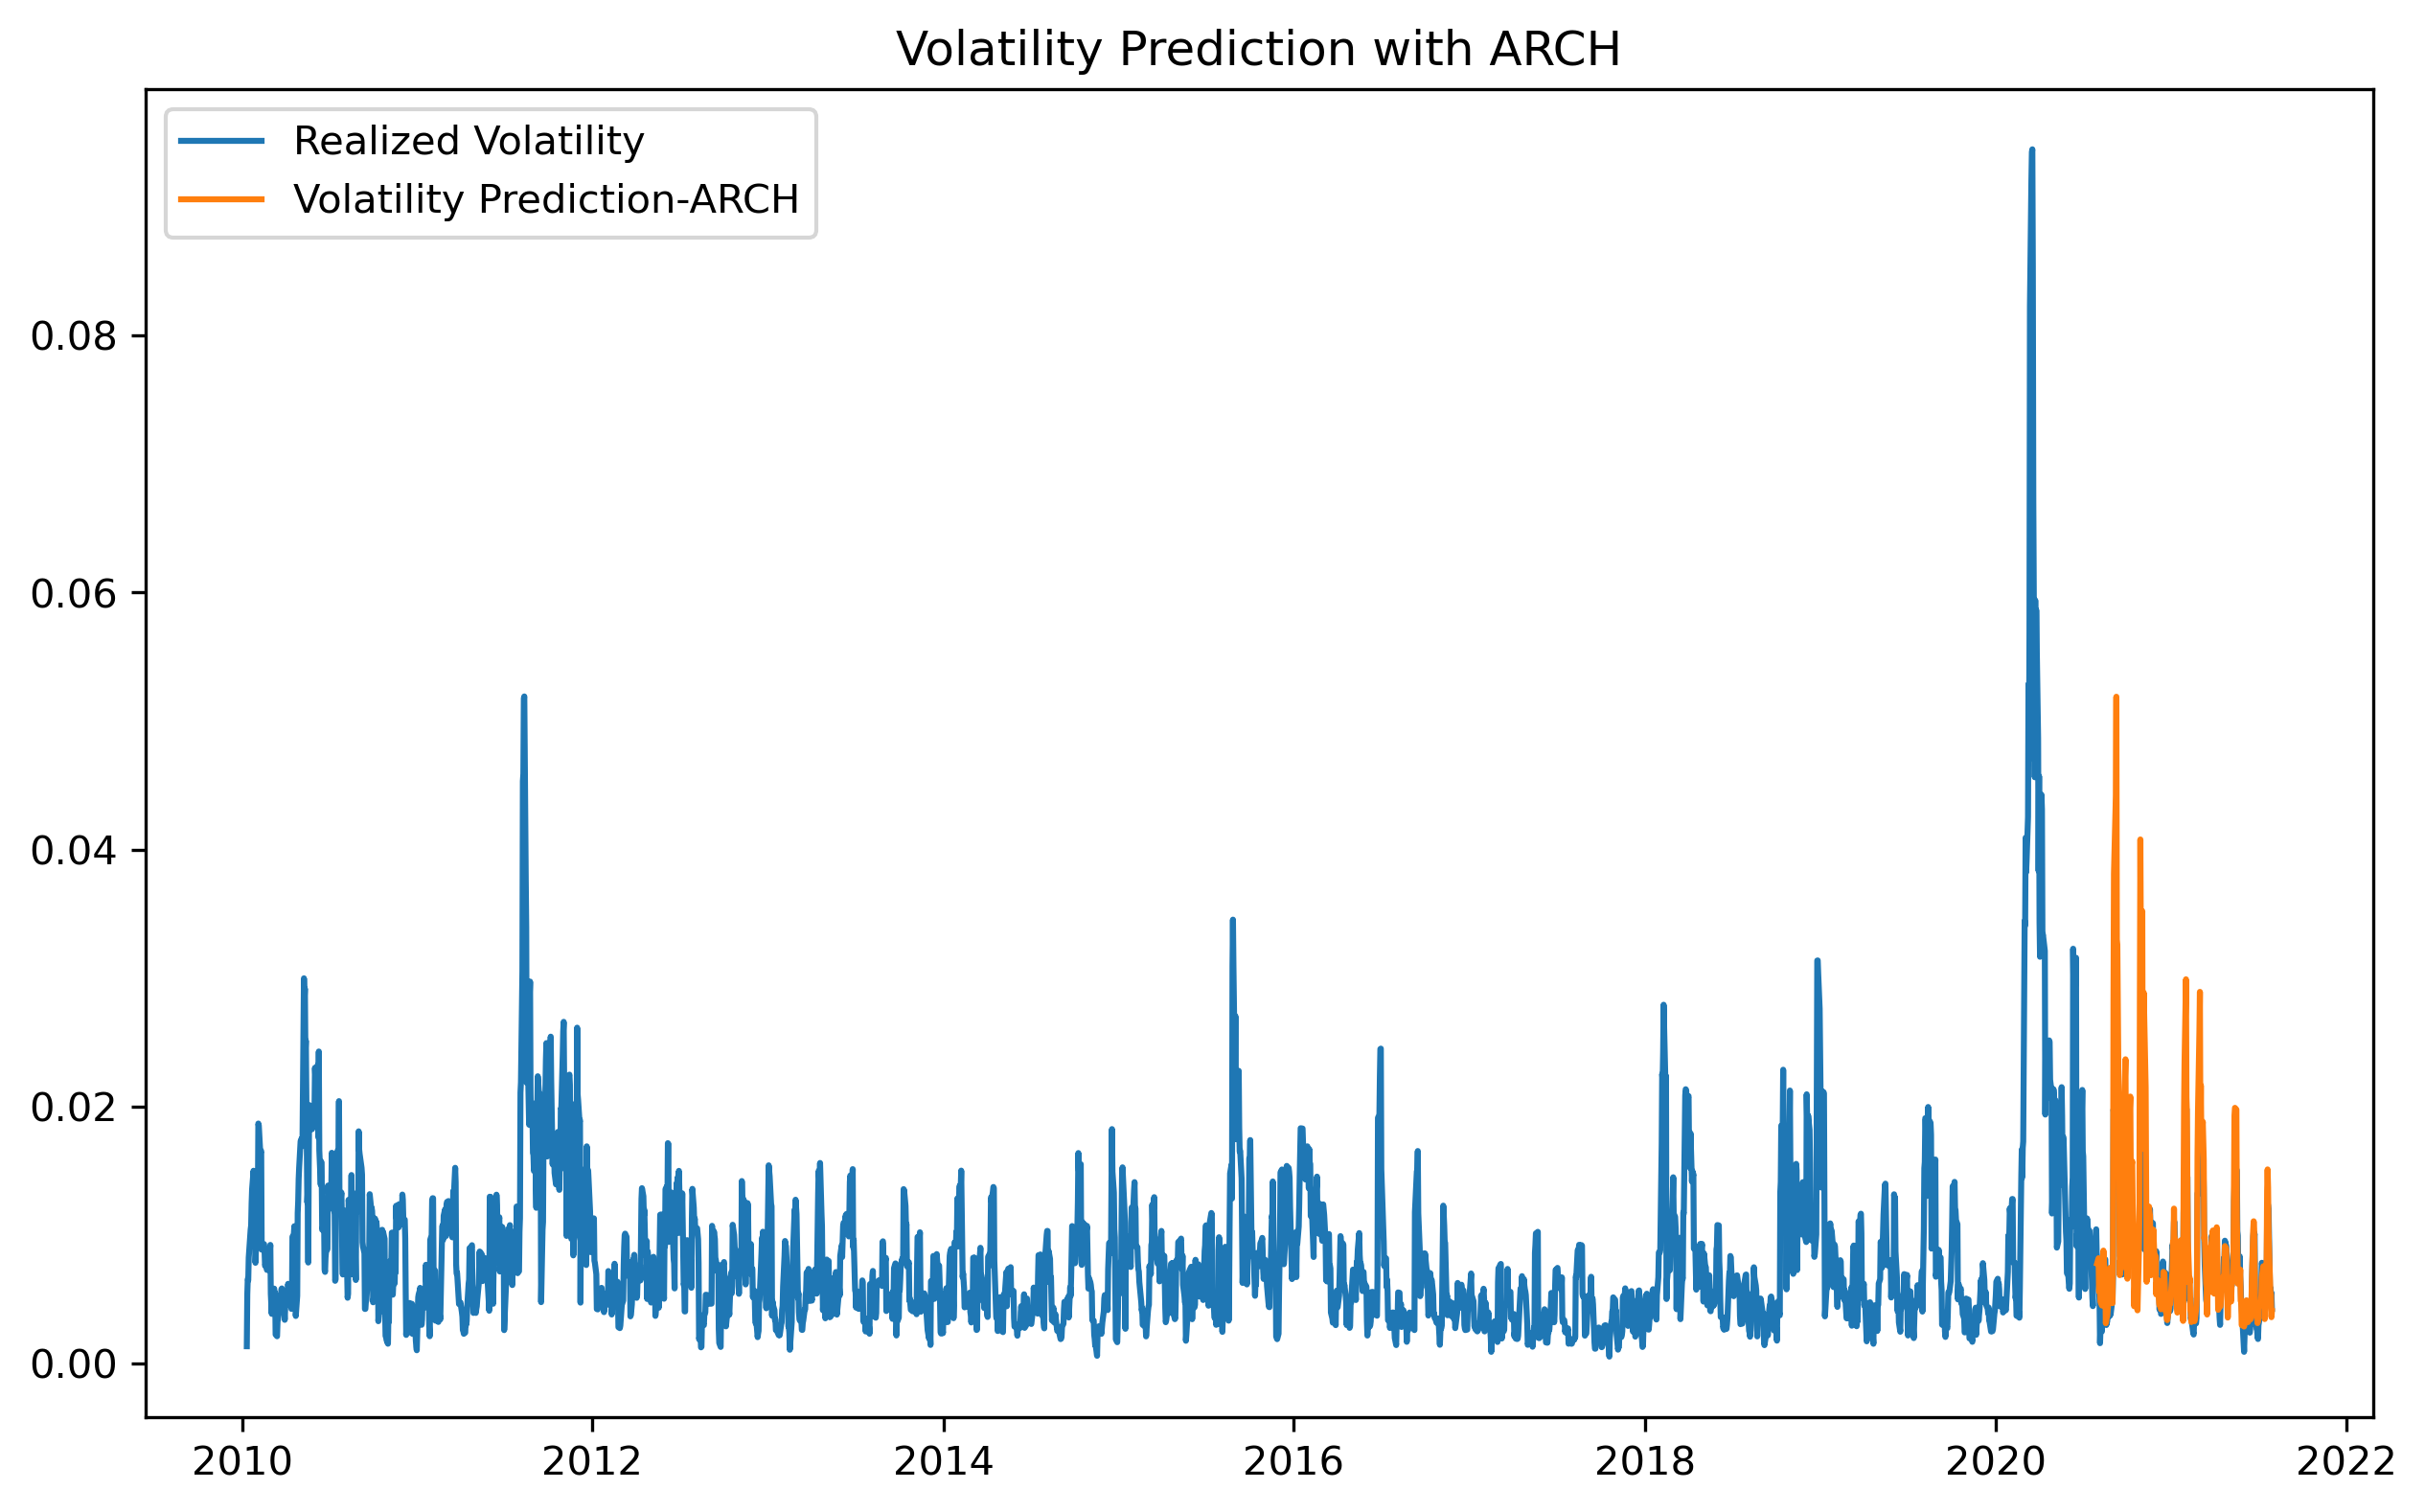

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

혹은 $\mathrm{ARCH}$모형의 차수를 정하기 위해서 residual인 $a_t^2$에 대해 Partial ACF 검정 값을 참고하는 방법도 존재한다.

In [19]:
a = ret - ret.mean()
a

Date
2010-01-05    0.259046
2010-01-06    0.002031
2010-01-07    0.347599
2010-01-08    0.235651
2010-01-11    0.122154
                ...   
2021-07-26    0.185699
2021-07-27   -0.523766
2021-07-28   -0.071148
2021-07-29    0.368094
2021-07-30   -0.593126
Name: Adj Close, Length: 2913, dtype: float64

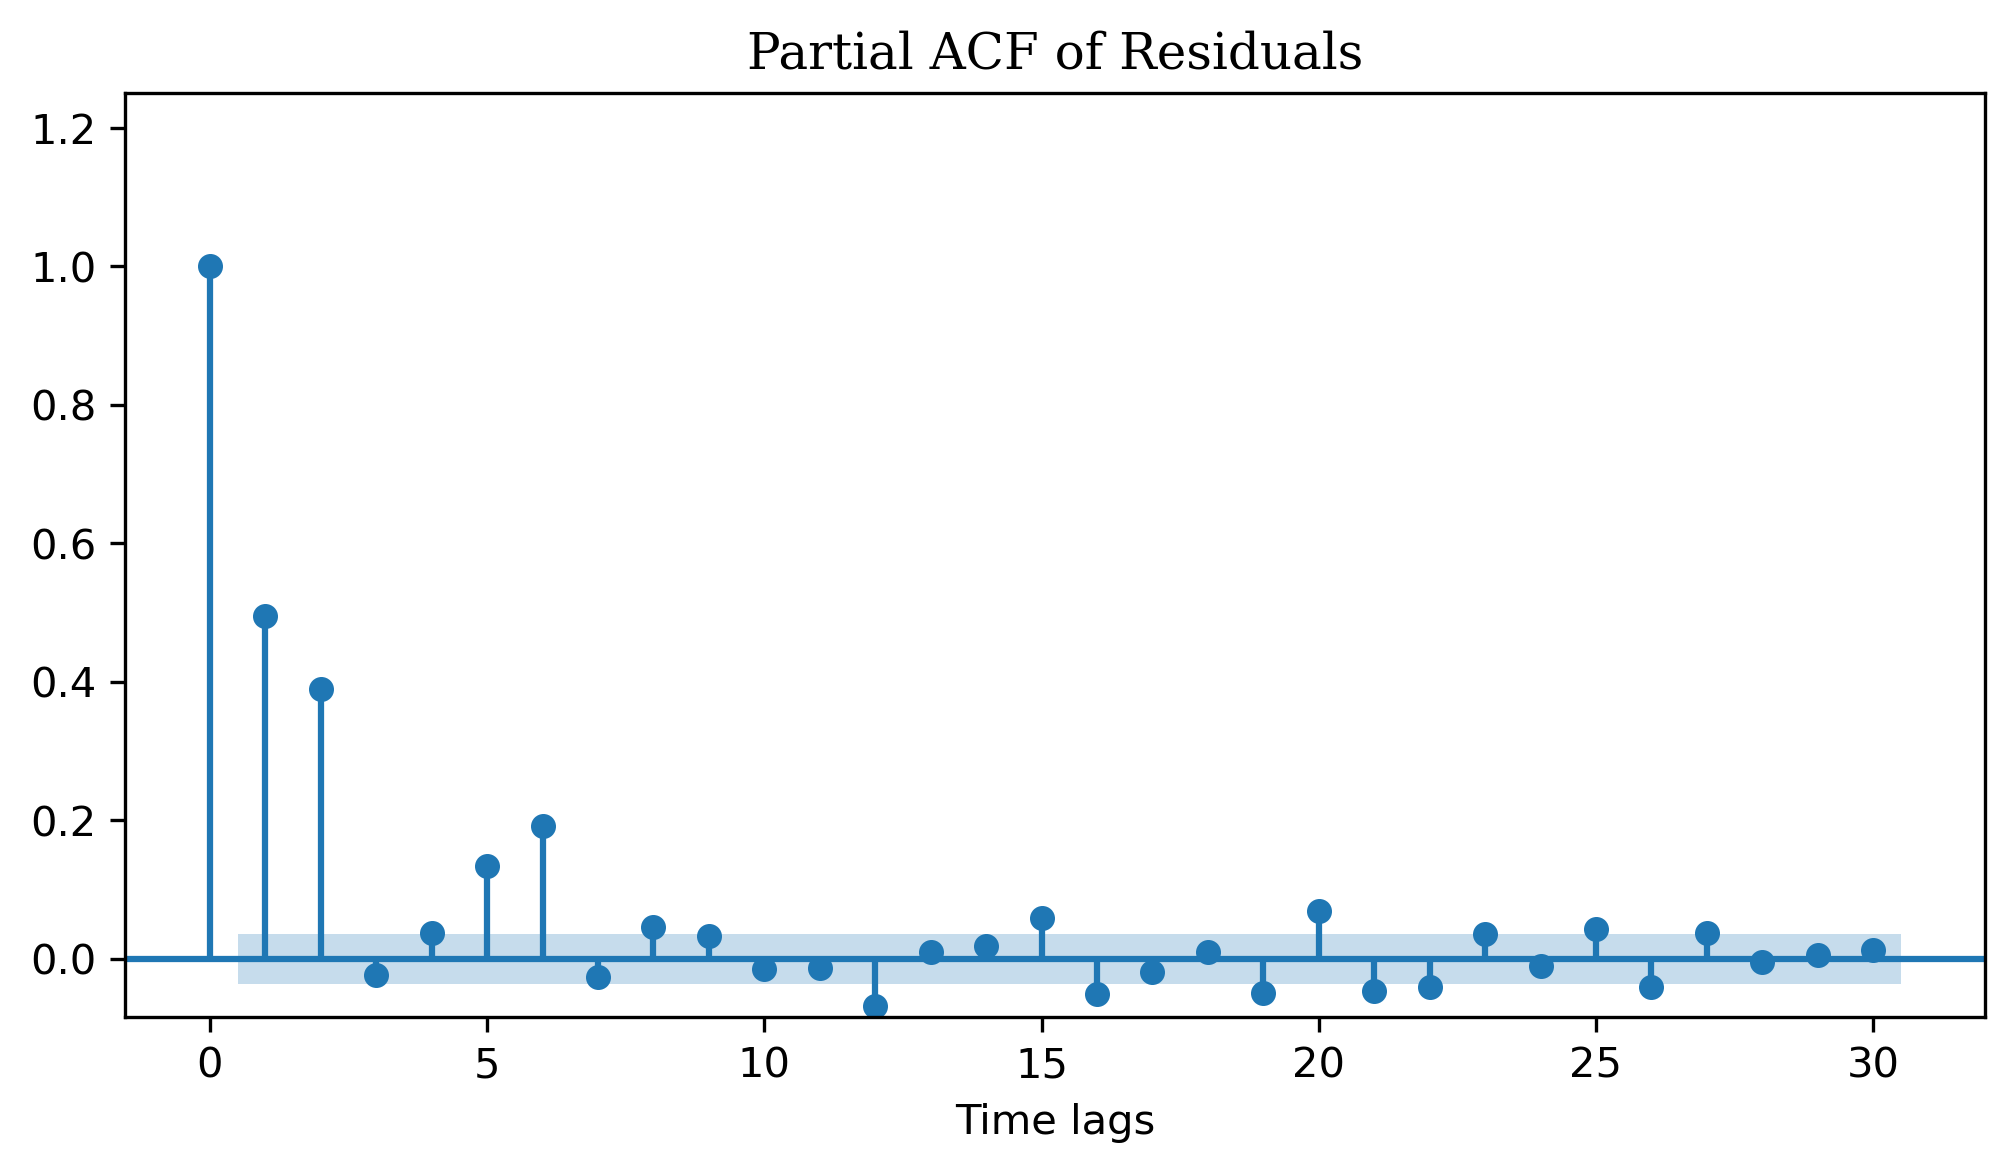

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(a**2, auto_ylims = True, lags = 30, title = 'ACF of KOSDAQ return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial ACF of Residuals', fontsize = 12, fontfamily = 'Serif')
plt.show()

이 경우 기각역을 벗어나는 5나 6을 p 값으로 사용할 수 있다.

## GARCH

$\mathrm{ARCH}$모형은 매우 간단하였지만, 앞서 설명한 단점과 더하여 추정해야 할 계수가 늘어난다는 단점 때문에 점차 더욱 간단한 모형에 대한 요구가 늘어나기 시작하였다. Boller slev는 $\mathrm{ARCH}$모형을 일반화한 Generalized ARCH ($\mathrm{GARCH}$)모형을 제안하였는데, 변동성에 대한 ARMA모형을 추정한 것과 유사한 형태이다. 변동성을 두개의 설명변수를 통해 추정하였기에 추정해야 할 parameter가 대폭 감소하는 장점이 있다

$a_t$가 $\mathrm{GARCH}(m,s)$모형을 따를 경우 다음과 같이 나타낼 수 있다

$$a_t = \sigma_t \epsilon_t, ~~~~~ \sigma_t^2 = \alpha_0 + \sum_{i=1}^m \alpha_i a_{t-1}^2 + \sum_{j=1}^s \beta_j \sigma_{t-j}^2$$

$\eta_t = a_t^2 - \sigma_t^2$라고 가정하면 $\mathrm{GARCH}$ 모형은 다음과 같이 표현 가능하다

$$a_t^2 = \alpha_0 + \sum_{i=1}^{\max (m,s)} (\alpha_i + \beta_i) a_{i-1}^2 + \eta_t - \sum_{j=1}^s \beta_j \eta_{t-j}$$

여기서 $\eta_t$는 martingale difference Series, iid sequence로써 다음과 같은 성질을 가진다
$$E(\eta_t) = 0$$
$$\mathrm{Cov}(\eta_t, \eta_{t-j}) = 0 ~~~ \mathrm{for} ~~ j \geq 1$$

$\mathrm{ARMA}$ 모형에서와 같이 $a_t^2$의 기대값을 다음과 같이 추정 가능하다

$$E(a_t^2) = \frac{\alpha_0}{1 - \Sigma_{i=1}^{\max (m,s)}(\alpha_i + \beta_i)}$$

$\mathrm{GARCH}(1,1)$모형의 경우

$$a_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + \beta_1 \sigma_{t-1}^2, ~~~~~ 0 \leq \alpha_1, \beta_1 \leq 1, (\alpha_1 + \beta_1) < 1$$

이다. 여기서 제약조건은 변동성이 **발산하지 않는다**로 해석할 수 있다

다음은 파이썬 코드를 이용해 GARCH 모델을 추정하는 과정이다

In [21]:
a0 = 0.0001
sgm2 = ret.var()
K = ret.kurtosis()
h = 1 - alpha / sgm2
alpha = np.sqrt(K * (1 - h ** 2) / (2.0 * (K + 3)))
beta = np.abs(h - omega)
omega = (1 - omega) * sgm2
initial_parameters = np.array([omega, alpha, beta])
print('Initial parameters for omega, alpha, and beta are \n{}\n{}\n{}'
      .format(omega, alpha, beta))

Initial parameters for omega, alpha, and beta are 
0.4350565592754937
0.5130099184547643
0.02663563269868552


In [22]:
retv = ret.values

In [23]:
@jit(nopython=True, parallel=True)
def garch_likelihood(initial_parameters, retv):
    omega = initial_parameters[0]
    alpha = initial_parameters[1]
    beta = initial_parameters[2]
    T =  len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 + beta * sigma2[t-1]
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks

In [24]:
logliks = garch_likelihood(initial_parameters, retv)
print('The Log likelihood  is {:.4f}'.format(logliks))

The Log likelihood  is 1386.4565


In [25]:
def garch_constraint(initial_parameters):  
    alpha = initial_parameters[0]
    gamma = initial_parameters[1]
    beta = initial_parameters[2]
    return np.array([1 - alpha - beta])

In [26]:
bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [27]:
def opt_paramsG(initial_parameters, retv):
    opt_result = opt.minimize(garch_likelihood, 
                              x0=initial_parameters,
                              constraints=np.array([1 - alpha - beta]), 
                              bounds=bounds, args = (retv),
                              method='Nelder-Mead',
                              options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'\
          .format('-' * 35, opt_result))
    print('-' * 35)
    print('\nResulting parameters = {}'.format(params))
    return params

In [28]:
params = opt_paramsG(initial_parameters, retv)


Results of Nelder-Mead minimization
-----------------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 978.4381678874333
             x: [ 3.925e-02  1.744e-01  7.894e-01]
           nit: 99
          nfev: 172
 final_simplex: (array([[ 3.925e-02,  1.744e-01,  7.894e-01],
                       [ 3.929e-02,  1.745e-01,  7.893e-01],
                       [ 3.927e-02,  1.744e-01,  7.894e-01],
                       [ 3.928e-02,  1.744e-01,  7.894e-01]]), array([ 9.784e+02,  9.784e+02,  9.784e+02,  9.784e+02]))
-----------------------------------

Resulting parameters = [0.0392492  0.17440926 0.78939289]


In [29]:
def garch_apply(ret):
        omega = params[0]
        alpha = params[1]
        beta = params[2]
        T = len(ret)
        sigma2 = np.zeros(T + 1)
        sigma2[0] = np.var(ret)
        for t in range(1, T):
            sigma2[t] = omega + alpha * ret[t - 1] ** 2 +\
                        beta * sigma2[t-1]
        return sigma2

다음은 내장 라이브러리를 이용해 GARCH 모델을 추정하는 과정이다

In [30]:
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1)\
        .fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Fri, Oct 18 2024   Df Residuals:                     2913
Time:                        17:11:34   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

다음은 BIC 값을 최소화하는 GARCH 차수를 찾아가는 과정이다

In [31]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Fri, Oct 18 2024   Df Residuals:                     2913
Time:                        17:11:34   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

일반적으로, $\mathrm{GARCH}$ 모형의 차수를 정하는 것은 쉽지 않다. 다만, 대부분의 경우 order가 (1,1), (1,2), (2,1)이기 때문에, 세 모형을 모두 추정 후 비교하여 선정하는 방식을 택한다


In [32]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                         np.sqrt(forecast_garch\
                         .variance.iloc[-len(split_date):] 
                         / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.0878


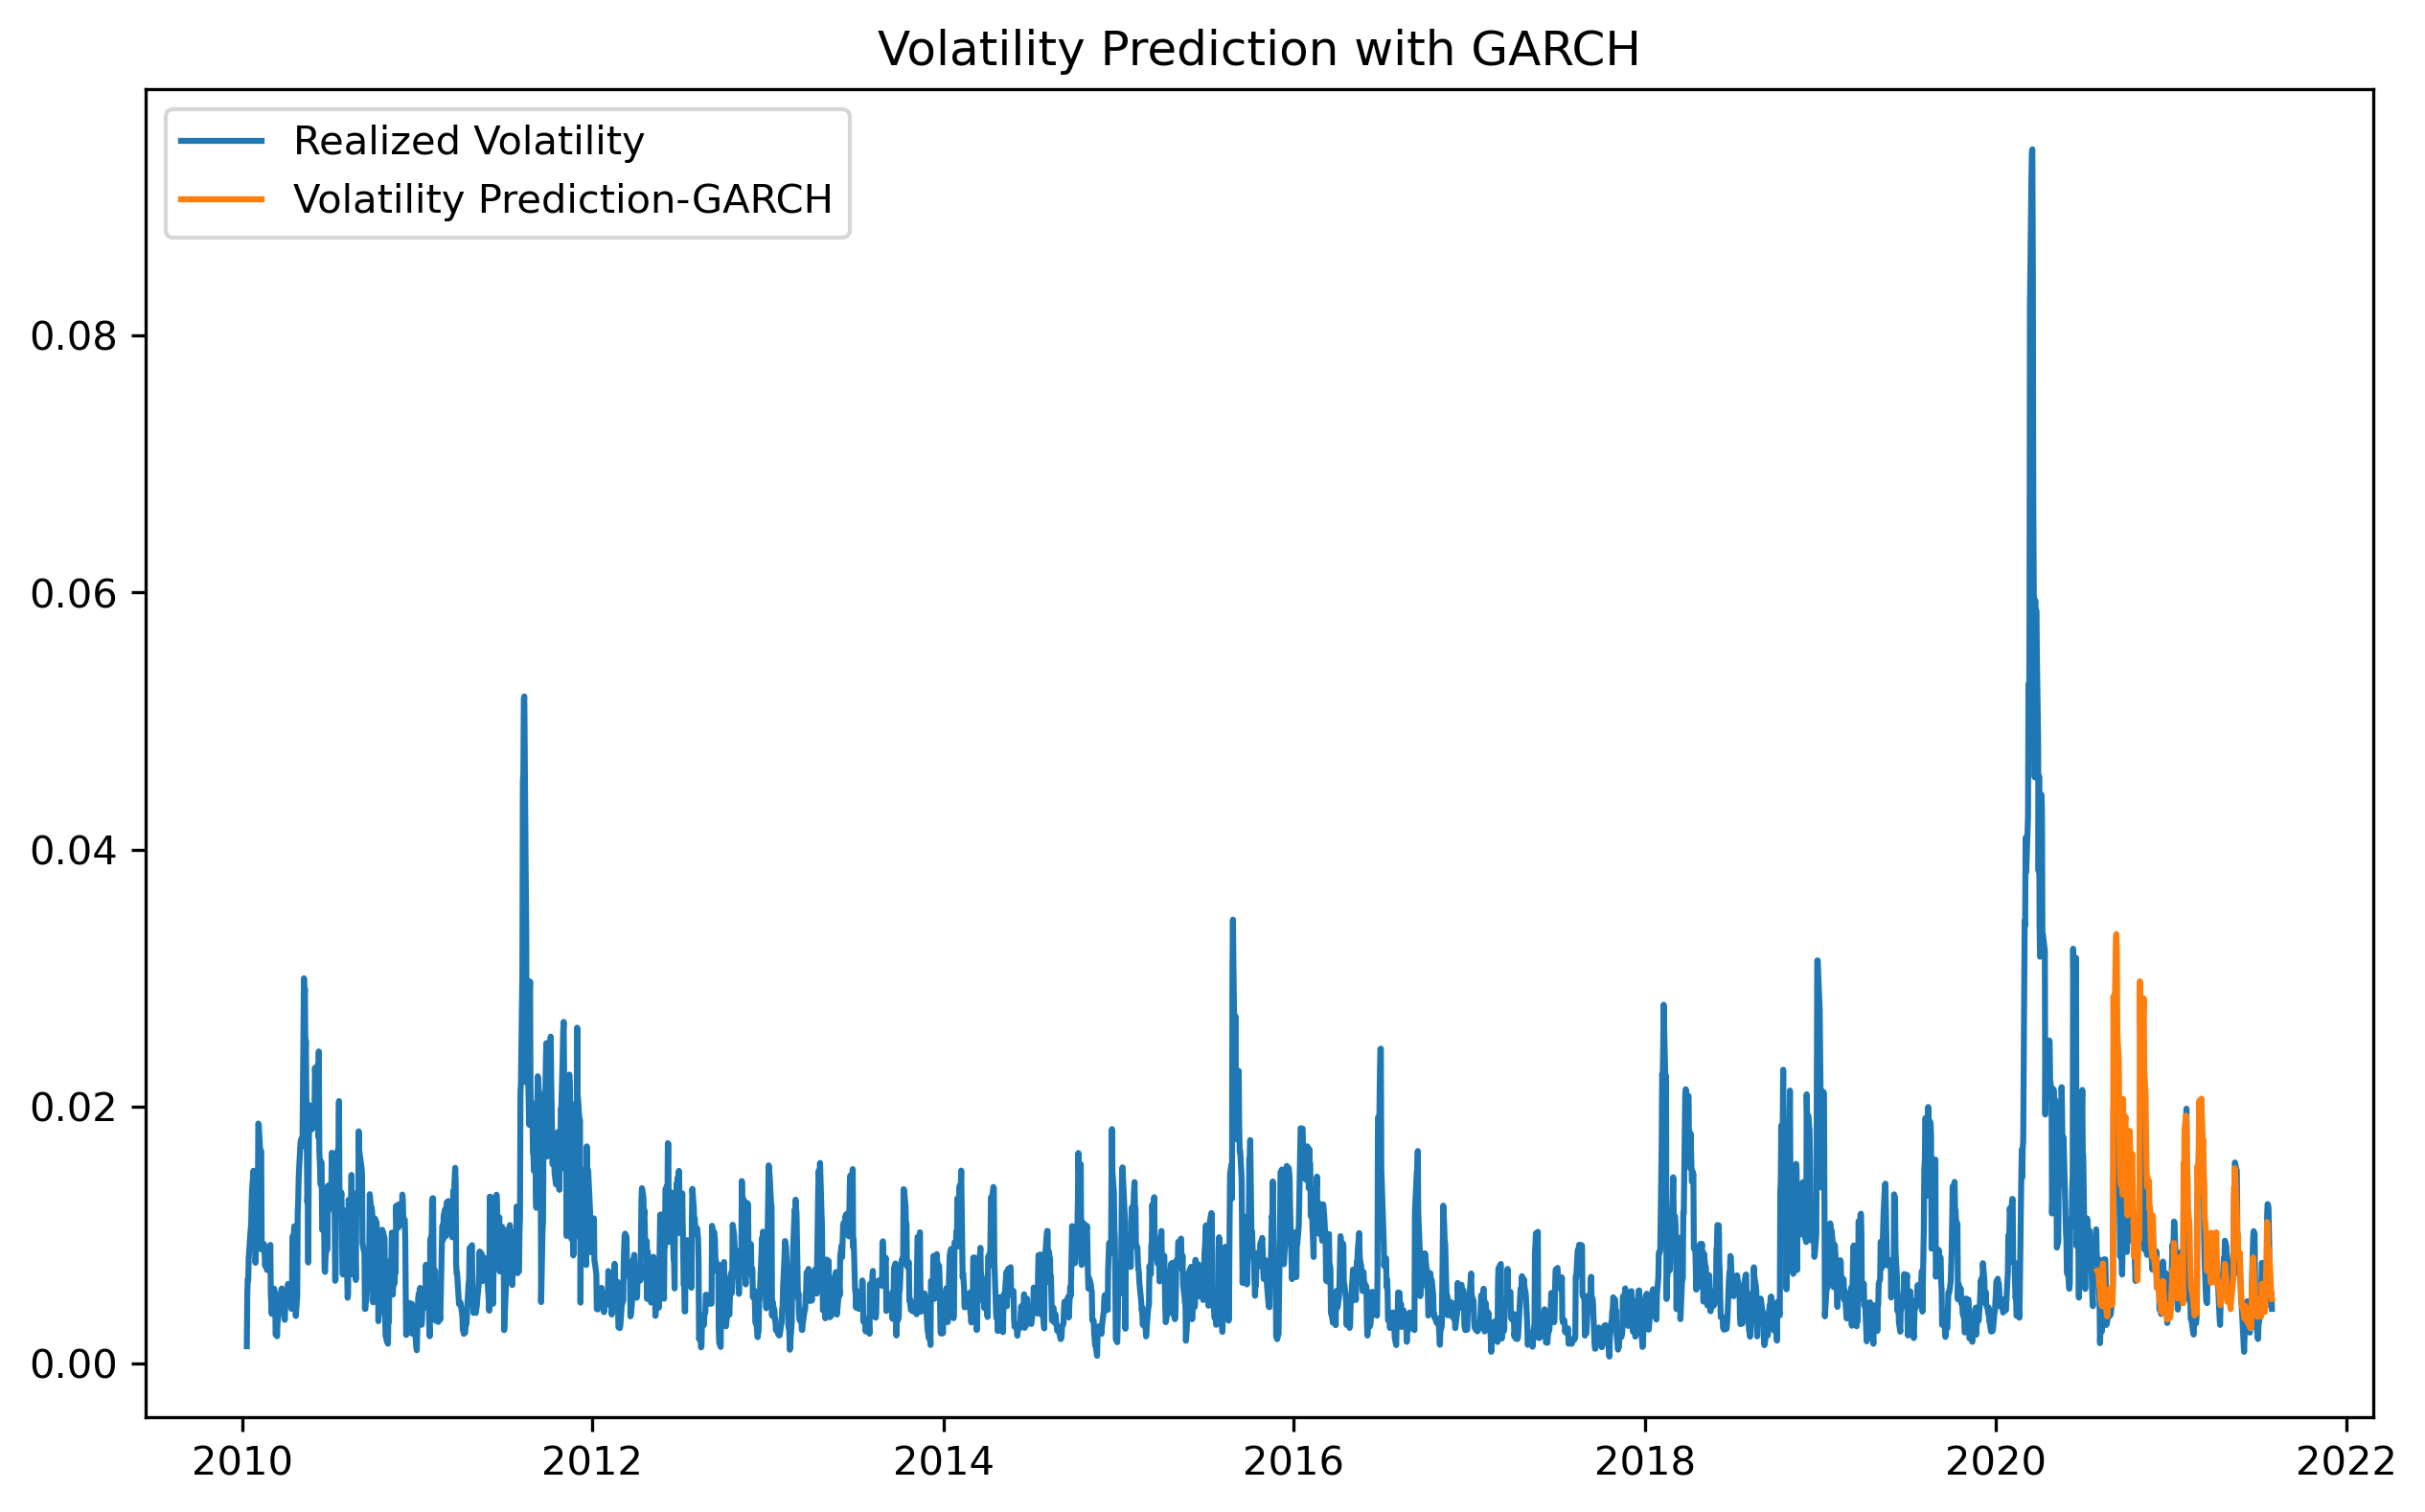

In [33]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

## GJR-GARCH

GJR-GARCH 모델은 수익률 분포의 비대칭성을 반영한다는 특성을 가지고 있다. 이는 나쁜 소식이 좋은 소식보다 더 큰 파급력을 미치는 현상을 잘 모델링한다. 모델의 방정식은 다음과 같은 형태를 가진다.

$$ \sigma_t^2=w+\Sigma_{k=1}^q(\alpha_k r^2_{t-k}+\gamma r^2_{t-k}I_{t-k}(\epsilon_{t-k}<0))+\Sigma_{k=1}^p \beta_k \sigma_{t-k}^2$$

여기서 $\gamma$가 발표의 비대칭성을 모델링한다. $\gamma$의 값에 따라 3가지 case를 가진다

- $\gamma=0$ : 과거 충격에 대한 반응은 긍정과 부정이 동일하다.

- $\gamma>0$ : 과거 부정적인 충격에 대한 반응이 긍정적인 충격에 대한 반응보다 더 강력하다

- $\gamma<0$ : 과거 긍정적인 충격에 대한 반응이 부정적인 충격에 대한 반응보다 더 강력하다

In [34]:
bic_gjr_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(ret, mean='zero', p=p, o=1, q=q)\
                   .fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
            best_param = p, q
gjrgarch = arch_model(ret,mean='zero', p=best_param[0], o=1,
                      q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3591.15
Distribution:                  Normal   AIC:                           7190.30
Method:            Maximum Likelihood   BIC:                           7214.21
                                        No. Observations:                 2913
Date:                Fri, Oct 18 2024   Df Residuals:                     2913
Time:                        17:11:35   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0430  7.754e-03      5.547  2.908e-08 

In [35]:
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                             np.sqrt(forecast_gjrgarch\
                             .variance.iloc[-len(split_date):]
                             / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'
      .format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.0882


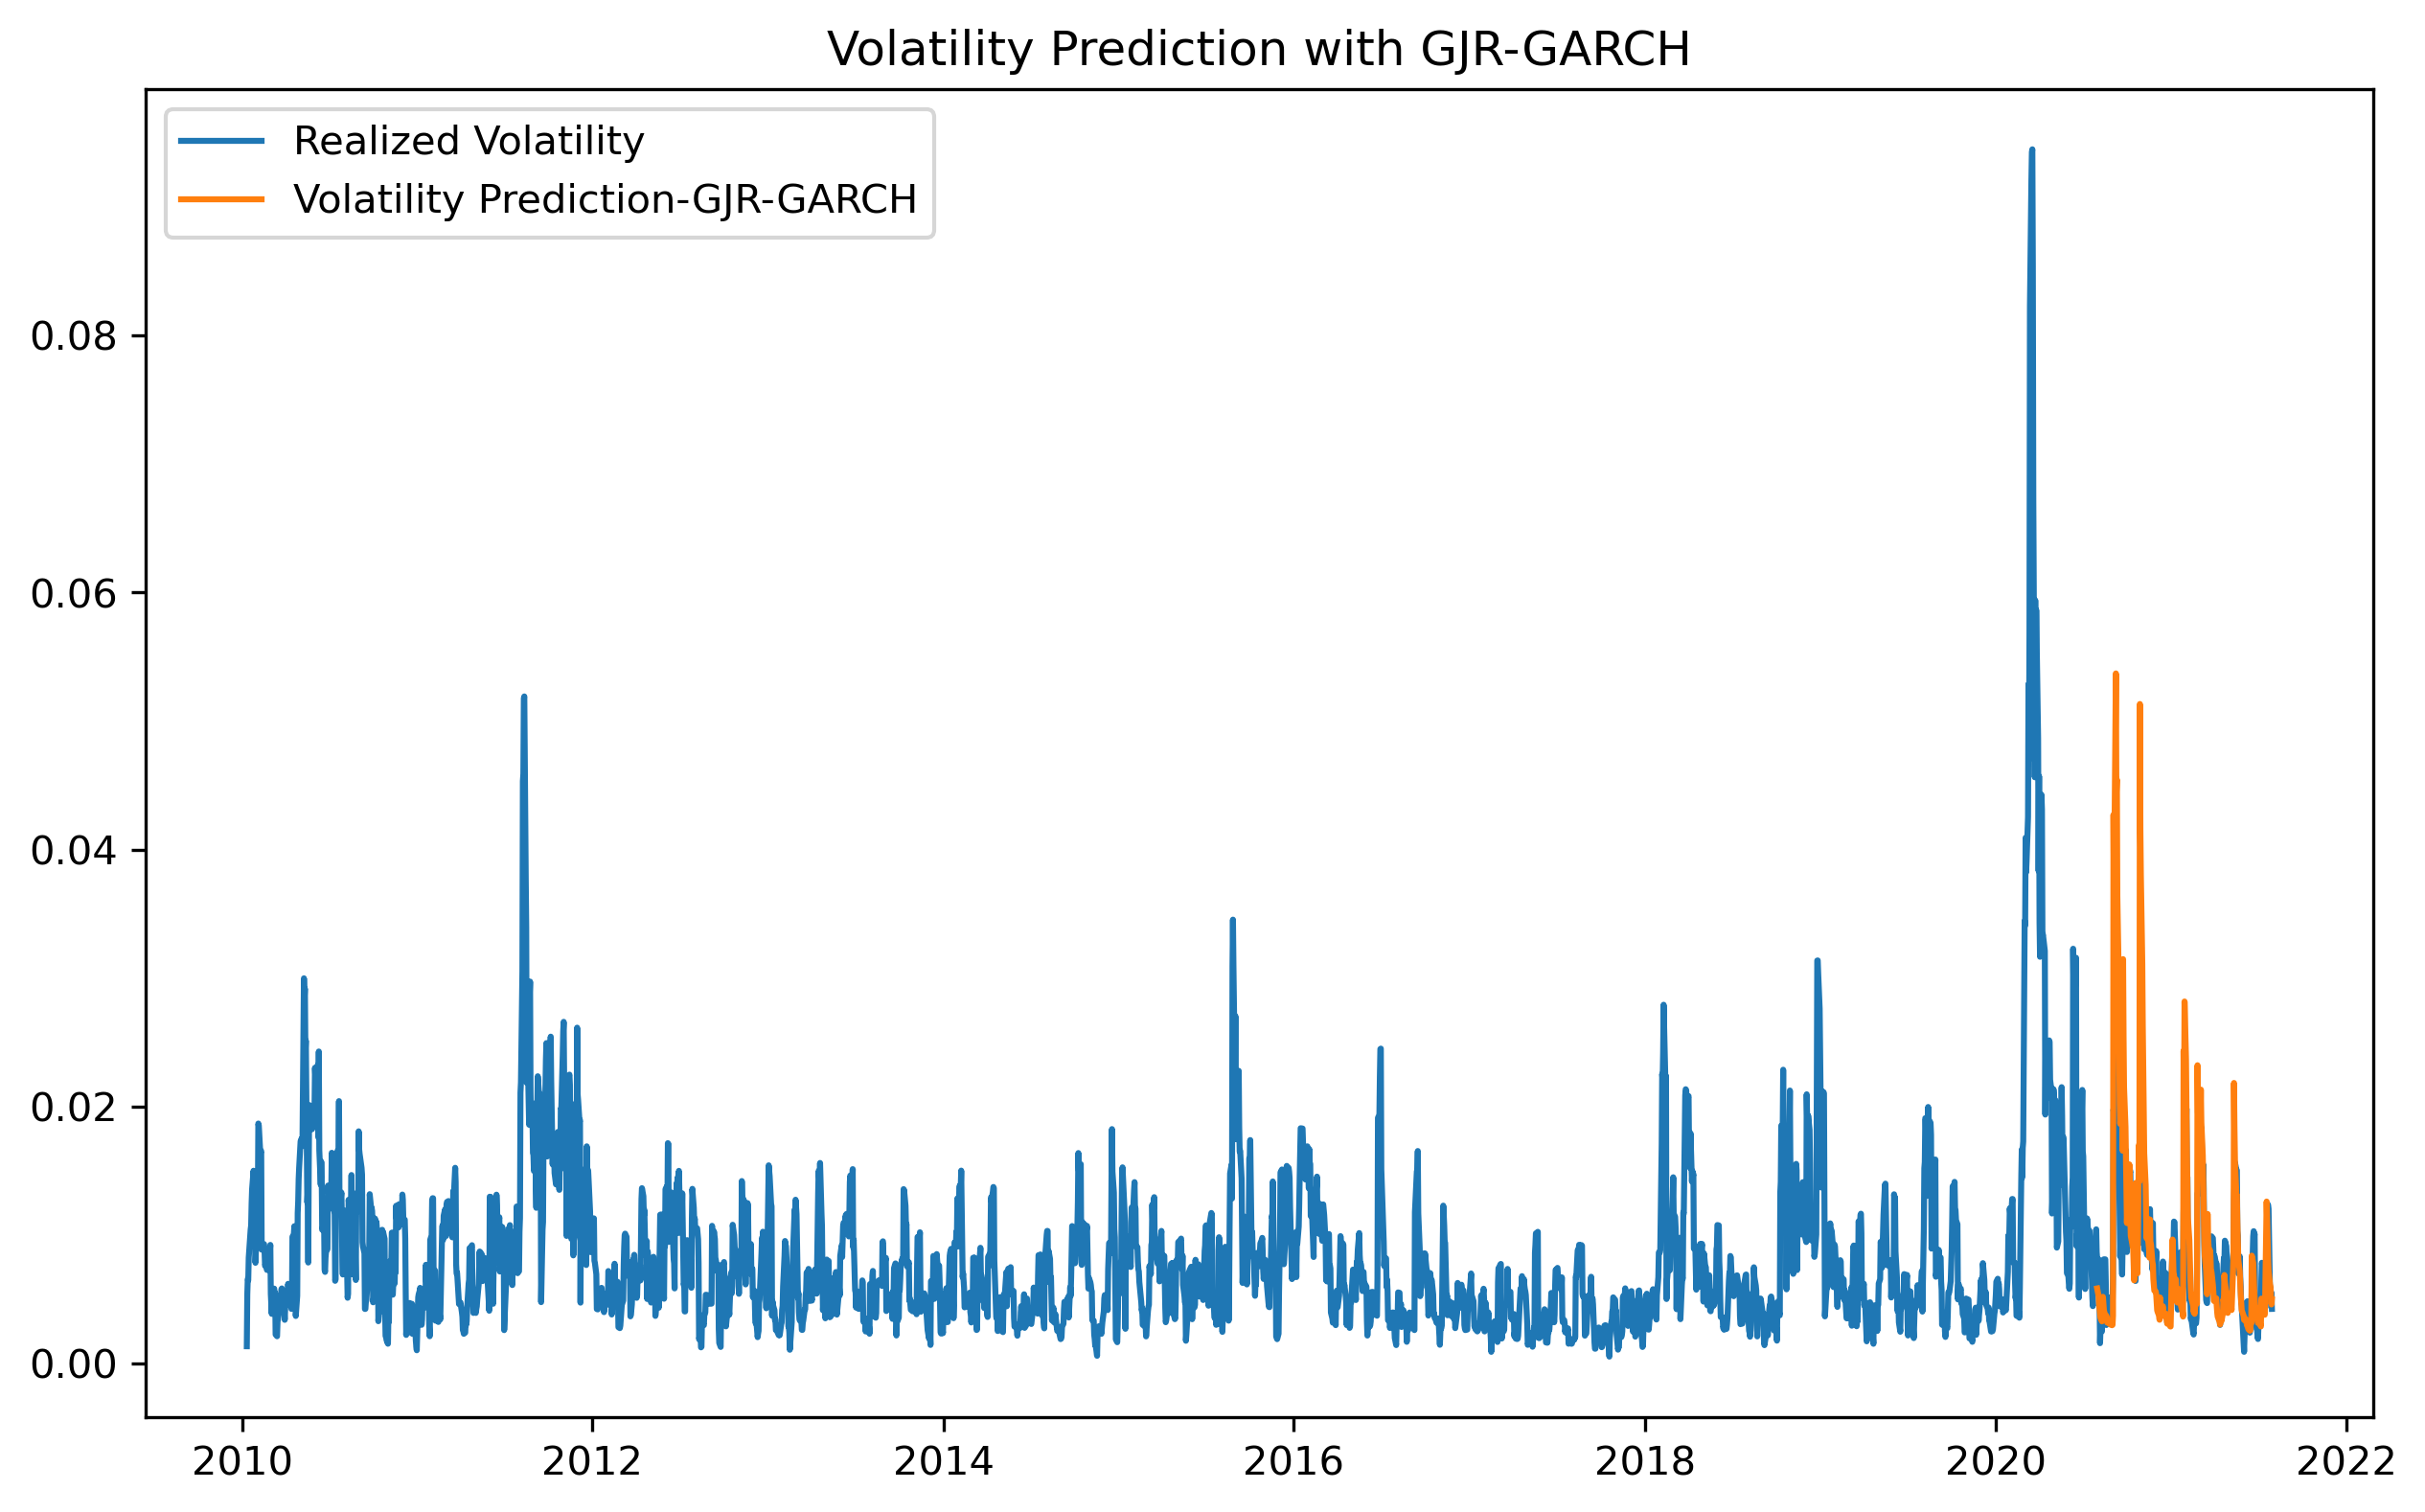

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

## EGARCH

EGARCH 또한 변동성의 비대칭 효과를 모델링하기 위해 설계된 모델이다. 더하여, EGARCH는 로그 형식으로 지정되므로 음의 변동성을 피하기 위한 추가적 제약이 필요 없다는 장점을 가진다.

EGARCH 방정식은 다음과 같다.

$$log(\sigma_t^2)=w+\Sigma_{k=1}^p \beta_k log(\sigma_{t-k}^2)+\Sigma_{k=1}^q \alpha_k \frac{\vert r_{t-k} \vert}{\sqrt {\sigma_{t-k}^2}} + \Sigma_{k=1}^q \gamma_k \frac{r_{t-k}}{\sqrt{\sigma_{t-k}^2}}$$



In [37]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q)\
                 .fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH',
                    p=best_param[0], q=best_param[1])\
         .fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3673.53
Distribution:                  Normal   AIC:                           7353.05
Method:            Maximum Likelihood   BIC:                           7370.98
                                        No. Observations:                 2913
Date:                Fri, Oct 18 2024   Df Residuals:                     2913
Time:                        17:11:36   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.4573e-03  6.769e-03      0.363      0.717 

In [38]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100,
                          np.sqrt(forecast_egarch.variance\
                          .iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.0904


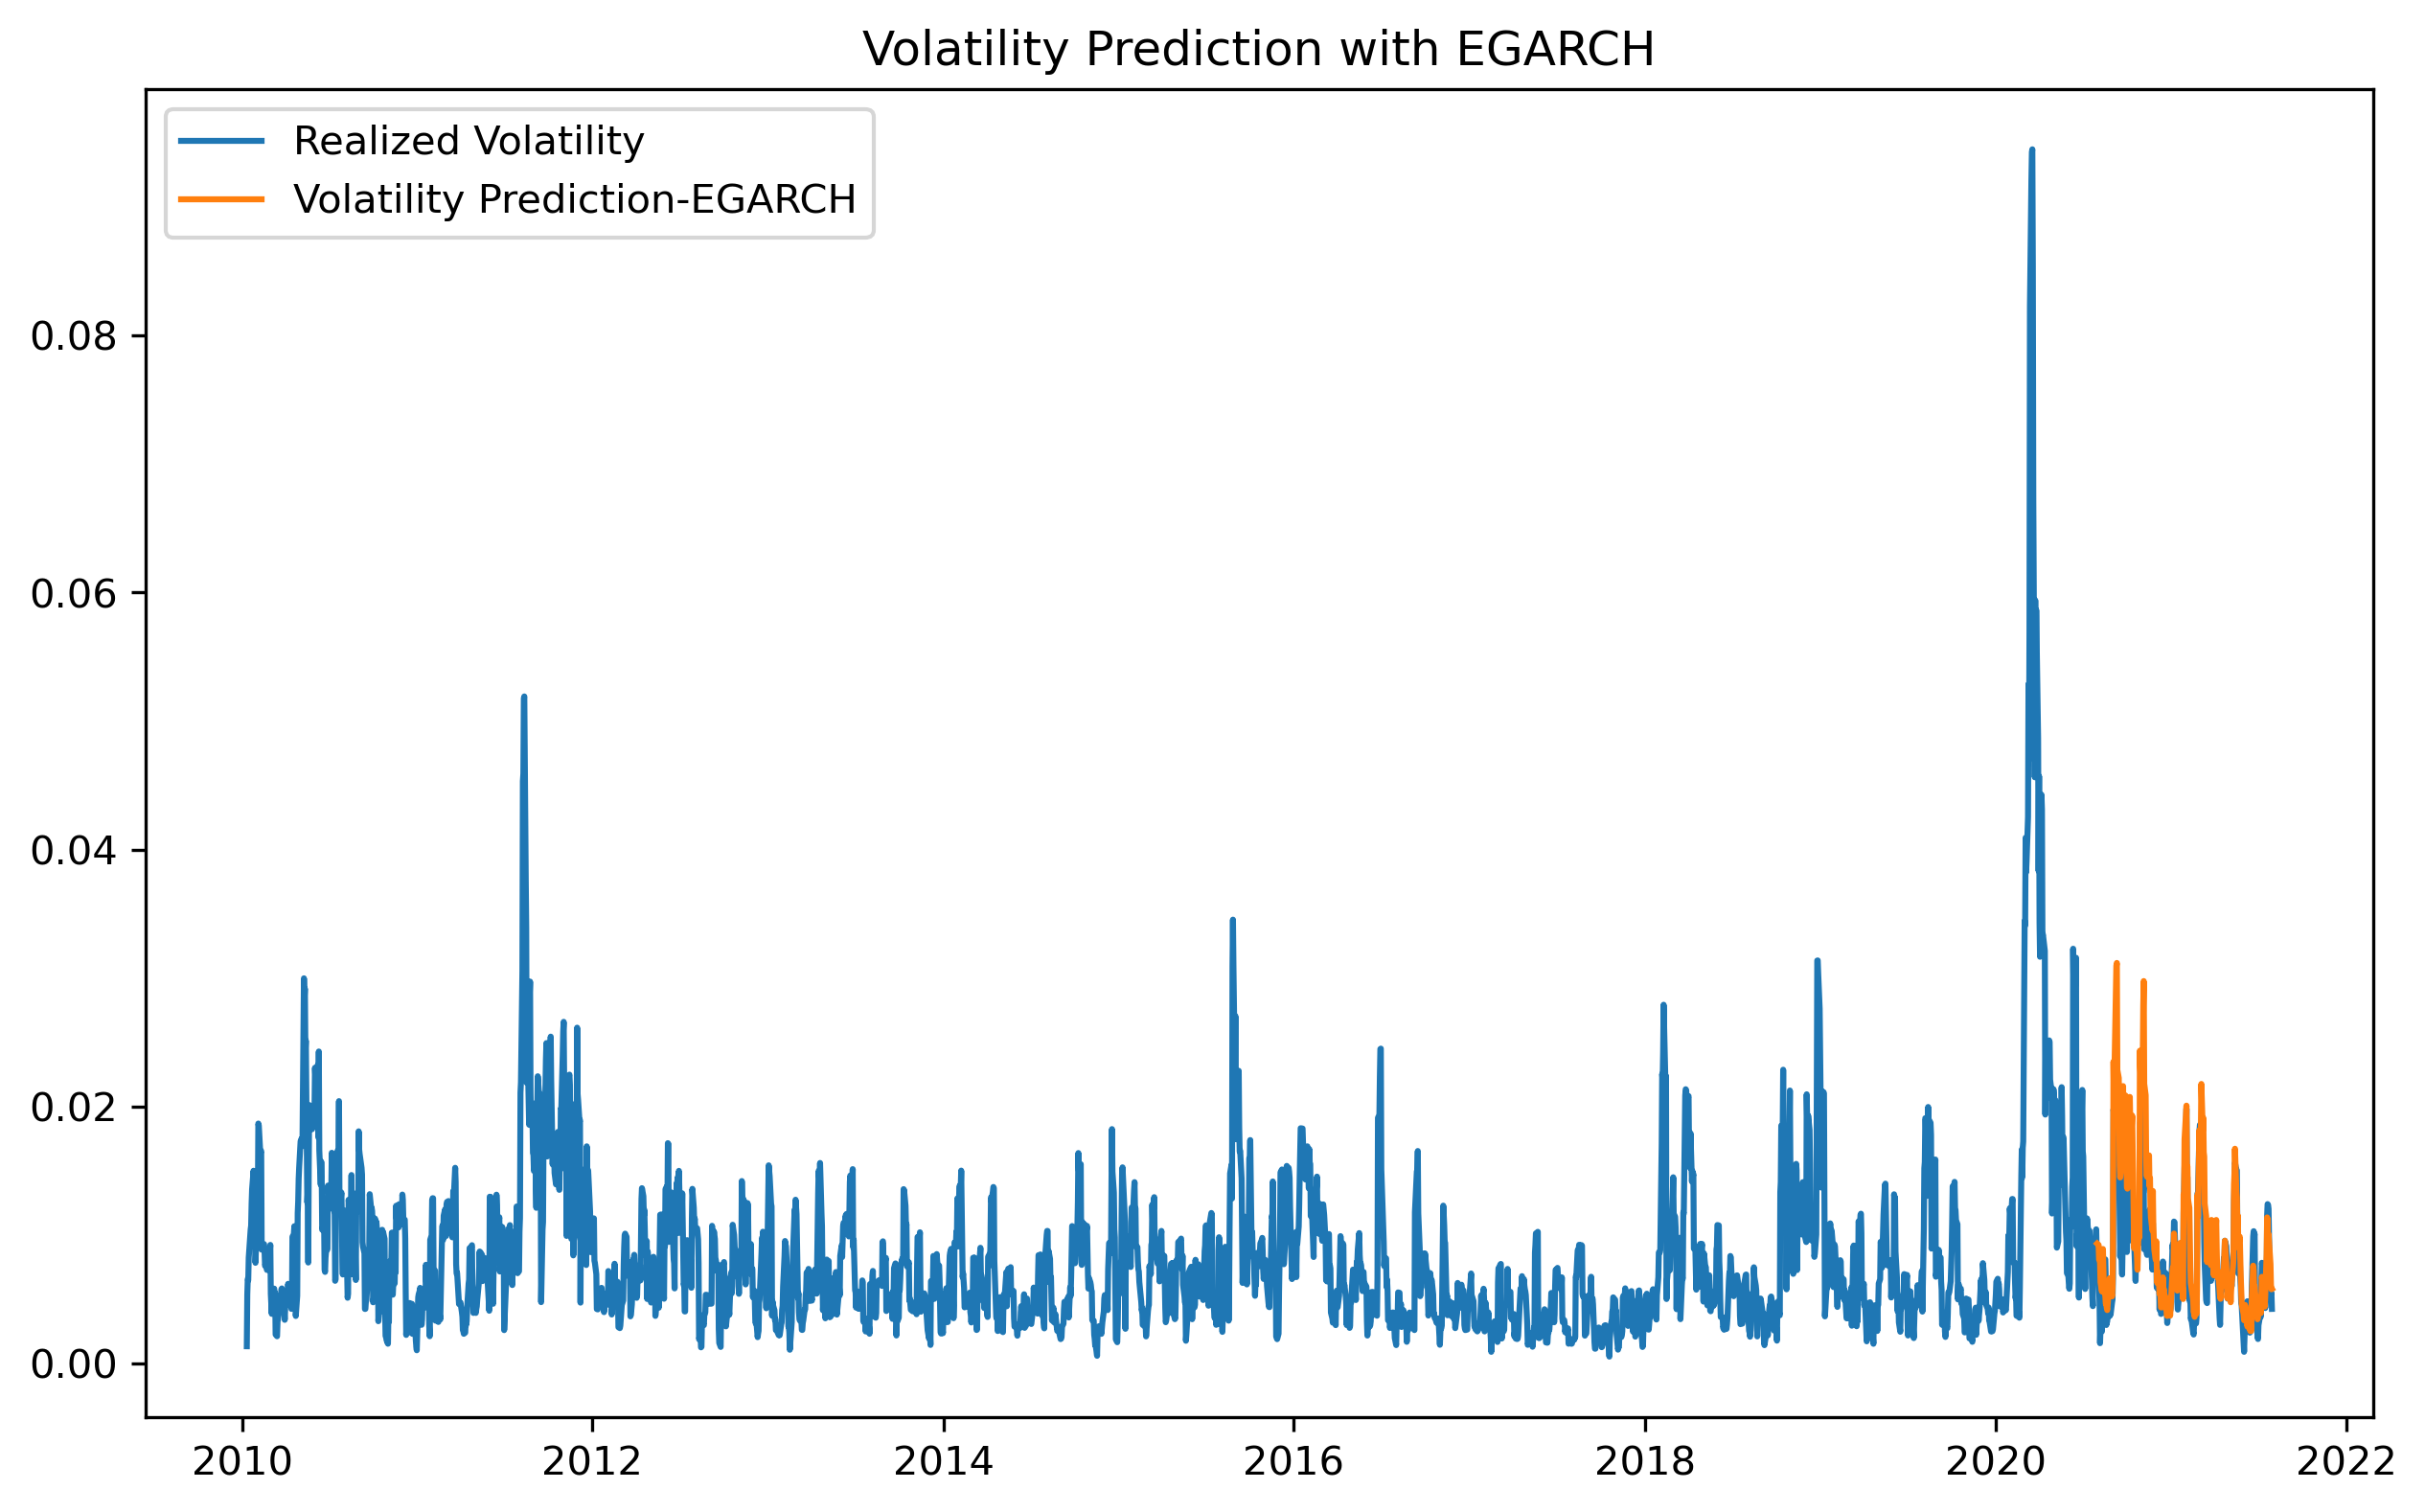

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

## Support Vector Machine

<center><img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/600px-SVM_margin.png" alt="My Image"></center>

Support Vector Machine은 분류를 목적으로 제안된 모형이다. 1992년 Vladimir N. Vapnik와 Alexey Ya. Chervonenkis에 의해 Hard Margin model이 처음 제안되었고, soft margin model은 Corinna Cortes and Vapnik에 의해 1995년에 제안된 모형이다. sklearn에서는 아래 함수를 통해 불러올 수 있다

```
sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, 
                probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
```

Regression의 Support Vector가 맨 바깥쪽에 위치한 것에 비해, Classification Model에서는 추정되는 결정 경계에 가장 가까운 vector가 support vector가 된다

#### Hard Margin Model

데이터가 아래와 같이 총 $n$개 있다고 가정하자

$$(x_1, y_1), \dots, (x_n, y_n)$$

여기서 $y_i$는 1과 -1으로 labeling된 정성 변수이다. SVM의 목적은 $y = -1$과 $y=1$로 labeling된 **데이터들의 거리를 최대화** 하는 것이다. 거리를 최대화하는 가상의 공간을 **Hyperplane(초평면)** 이라고 하며, 다음의 식을 만족한다

$$\mathbf{w}^T \mathbf{x} - b = 0$$

여기서 $\mathbf {w} $는 초평면의 normal vector, $b$는 bias(=intercept)이다. 추정해야하는 parameter  ${\frac {b}{\|\mathbf {w} \|}} $는 $\mathbf {w} $에 의해 결정된다

$y = -1$과 $y=1$로 labeling된 데이터들은 다음을 만족할 것이다

$${\displaystyle \mathbf {w} ^{\mathsf {T}}\mathbf {x} _{i}-b\geq 1\,,{\text{ if }}y_{i}=1}$$
$${\displaystyle \mathbf {w} ^{\mathsf {T}}\mathbf {x} _{i}-b\leq -1\,,{\text{ if }}y_{i}=-1}$$

이러한 제약 조건은 각 데이터 점이 여백의 올바른 쪽에 놓여 있어야 함을 나타내며, 다음과 같이 다시 쓸 수 있다

$${\displaystyle y_{i}(\mathbf {w} ^{\mathsf {T}}\mathbf {x} _{i}-b)\geq 1,\quad {\text{ for all }}1\leq i\leq n}$$

이를 조합하면 다음과 같은 최적화 문제를 얻을 수 있다

$${\displaystyle {\begin{aligned}&{\underset {\mathbf {w} ,\;b}{\operatorname {minimize} }}&&\|\mathbf {w} \|_{2}^{2}\\&{\text{subject to}}&&y_{i}(\mathbf {w} ^{\top }\mathbf {x} _{i}-b)\geq 1\quad \forall i\in \{1,\dots ,n\}\end{aligned}}}$$

최적화 문제에서 추정된 $\mathbf {w} $와 $b$는 어느 support vector들간의 거리를 최대화하는(${\displaystyle \mathbf {x} \mapsto \operatorname {sgn}(\mathbf {w} ^{\mathsf {T}}\mathbf {x} -b)}$) 값이다

#### Soft Margin Model

Hard Margin Model의 고질적인 Overfit 문제로 인해 탄생한 모형이다. Support vector간의 거리 최대화에 어느정도의 유연성을 인정한다

Soft Margin Model에서 목적은 다음과 같이 달라진다

$${\displaystyle \lambda \lVert \mathbf {w} \rVert ^{2}+\left[{\frac {1}{n}}\sum _{i=1}^{n}\max \left(0,1-y_{i}(\mathbf {w} ^{\mathsf {T}}\mathbf {x} _{i}-b)\right)\right]}$$

여기서 parameter $\lambda >0 $는 margin size를 조정해주는 hyper parameter이다. $\lambda$의 값이 0에 가까울수록 모형이 더욱 엄격해지며, 큰 값이 될 수록 모형이 유연해진다. 최적화 문제는 여기서 다음과 같이 다시 정의된다

$${\displaystyle {\begin{aligned}&{\underset {\mathbf {w} ,\;b,\;\mathbf {\zeta } }{\operatorname {minimize} }}&&\|\mathbf {w} \|_{2}^{2}+C\sum _{i=1}^{n}\zeta _{i}\\&{\text{subject to}}&&y_{i}(\mathbf {w} ^{\top }\mathbf {x} _{i}-b)\geq 1-\zeta _{i},\quad \zeta _{i}\geq 0\quad \forall i\in \{1,\dots ,n\}\end{aligned}}}$$

$C$값이 큰 경우 입력 데이터가 선형 분류 가능한 경우 Hard Margin SVM과 유사하게 동작하지만, $C$값이 작을수록 모형이 단순해진다. 일반적으로 $C$와 $\lambda$는 반비례 관계에 있다

#### Nonlinear Kernels

<center><img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Kernel_Machine.svg/1920px-Kernel_Machine.svg.png" alt="My Image"></center>

Kernel function을 SVM에 적용하면 Feature map이 비선형적 공간에 선형적인 공간으로 mapping되며 비선형적 모형도 추정이 가능하다. 복잡한 모형 또한 직관적으로 해석할 수 있다는 장점이 있지만, 연산량이 비대하여 학습 시간이 굉장히 오래 걸린다. 대표적인 kernel로는 다음과 같은것이 존재한다

**Polynoimal**

$${\displaystyle k(\mathbf {x} _{i},\mathbf {x} _{j})=(\mathbf {x} _{i}\cdot \mathbf {x} _{j})^{d}}$$

여기서 $d = 1$이면 lienar kernel과 같다

**Gaussian radial basis function**

$${\displaystyle k(\mathbf {x} _{i},\mathbf {x} _{j})=\exp \left(-\gamma \left\|\mathbf {x} _{i}-\mathbf {x} _{j}\right\|^{2}\right)} \ \mathbf{ for } \ \gamma >0.$$

**Sigmoid function**

$${\displaystyle k(\mathbf {x_{i}} ,\mathbf {x_{j}} )=\tanh(\kappa \mathbf {x} _{i}\cdot \mathbf {x} _{j}+c)} $$

sklearn의 SVM에서는 kernel에서 지정 가능하다. 위에서부터 각각 `'polynomial', 'rbf', 'sigmoid'`로 지정할 수 있다. 기본값은 `rbf`이다

```
sklearn.svm.SVC(kernel = 'polynomial', degree = 3)
sklearn.svm.SVC(kernel = 'rbf') # default
sklearn.svm.SVC(kernel = 'sigmoid')
```


서포트 벡터 머신은 분류를 위헤 제안된 모델이나, 동일한 방법론을 이용해 회귀에 사용할 수 있다. SVR-GARCH는 SVR(Support Vector Regression)과 GARCH 모델을 결합한 모델이다.

### Support Vector Regression

1995년, Vapnik와 Cortes는 Support Vector Network라는 모형을 제안하였다

```
sklearn.svm.SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
```

주요 Hyper Parameter는 다음과 같다

- kernel : SVM 커널 함수를 지정한다
- degree : kernel을 poly, 즉 비선형으로 지정하였을 때 지정하는 차수이다. 기본값은 3이며 값이 커질수록 모형이 복잡해진다
- coef0 : y intercept를 지정한다
- C : L2 score (Ridge)를 비용함수로 지정한다. 값이 작아질수록 일반화 성능이 커진다. 기본값은 1이다


https://link.springer.com/article/10.1007/BF00994018

#### Hard Margin Model

Hard Margin Model의 손실함수는 다음을 최적화하는 것을 목적으로 한다

$$\mathrm{Loss_{SVR}} = \min_w ||w||^2 + \lambda(\frac{1}{2}\sum_{i = 1}^n (y_i - f(x_i))^2)$$

여기서 $||w||^2$는 데이터와 회귀선과의 거리를 나타내는데, 이는 선형회귀식에서 오차를 최소화하는 식과 유사함을 알 수 있다.

#### Soft Margin Model

<center><img src = "https://leejiyoon52.github.io/images/image_67.png" alt="My Image"></center>

과적합이나 기타 일반화 성능 향상을 위해, 보통은 아래와 같은 손실함수를 최적화하는 것을 목적으로 한다

$$\mathrm{Loss_{SVR}} = \min_w \frac{1}{2}||w||^2 + C\sum_{i = 1}^n (\xi_i + \xi_i^*)$$
$$\mathrm{such~that~} (w^T x_i + b) - y_i \leq \epsilon + \xi_i$$
$$y_i - (w^T x_i + b) \leq \epsilon + \xi_i^*$$
$$\xi_i, \xi_i^* \geq 0$$

추정된 회귀식에서 상단과 하단에 각각 $\epsilon$만큼 마진을 생성하여 추정식의 허용 범위를 넓혀 준다. 즉, margin 값을 크게 줄 수록 모형의 노이즈 허용 범위가 커지는 것이다

비용함수 최적화에 있어서 Lagrangian Problem으로 해를 찾는 것이 가능하지만, 그 과정이 길기 때문에 우선은 생략한다. Lagrangian Dual Problem은 다음과 같이 정리된다

$$\mathcal{L_D} = \frac{1}{2}\sum_{i,j = 1}^n (\alpha_i^* - \alpha_i)(\alpha_j^* - \alpha_j) \mathbf{x_i}^T\mathbf{x_j} - \epsilon \sum_{i,j = 1}^n(\alpha_i^* - \alpha_i) + \sum_{i,j = 1}^n y_i(\alpha_i^* - \alpha_i)$$
$$\mathrm{such ~ that ~} \sum_{i=1}^n (\alpha_i^* - \alpha_i) = 0, ~~~~~ \alpha_i, \alpha_i^* \in [0,C]$$

Lagrangian dual problem으로 재구성한 목적식은 $α$로 이루어져있는 convex하고, 연속적인 quadratic programming problem이다. 최적화 프로그램을 이용한다면 간편하게 $α$를 도출할 수 있다

## SVR-GARCH

SVR(Support Vector Regression)을 GARCH 모델에 결합하면 SVR-GARCH 모델이 된다. SVR-GARCH 모델을 구축하기 위해서는 실현 변동성과 과거 수익률의 제곱 데이터를 얻어와야 한다.

In [40]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [41]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [42]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']

In [43]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [44]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [45]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

### SVR-GARCH-Linear

첫번째로 선형 커널을 이용해본다

In [46]:
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

In [47]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [48]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                       predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
      .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.000271


In [49]:
realized_vol.index = ret.iloc[4:].index

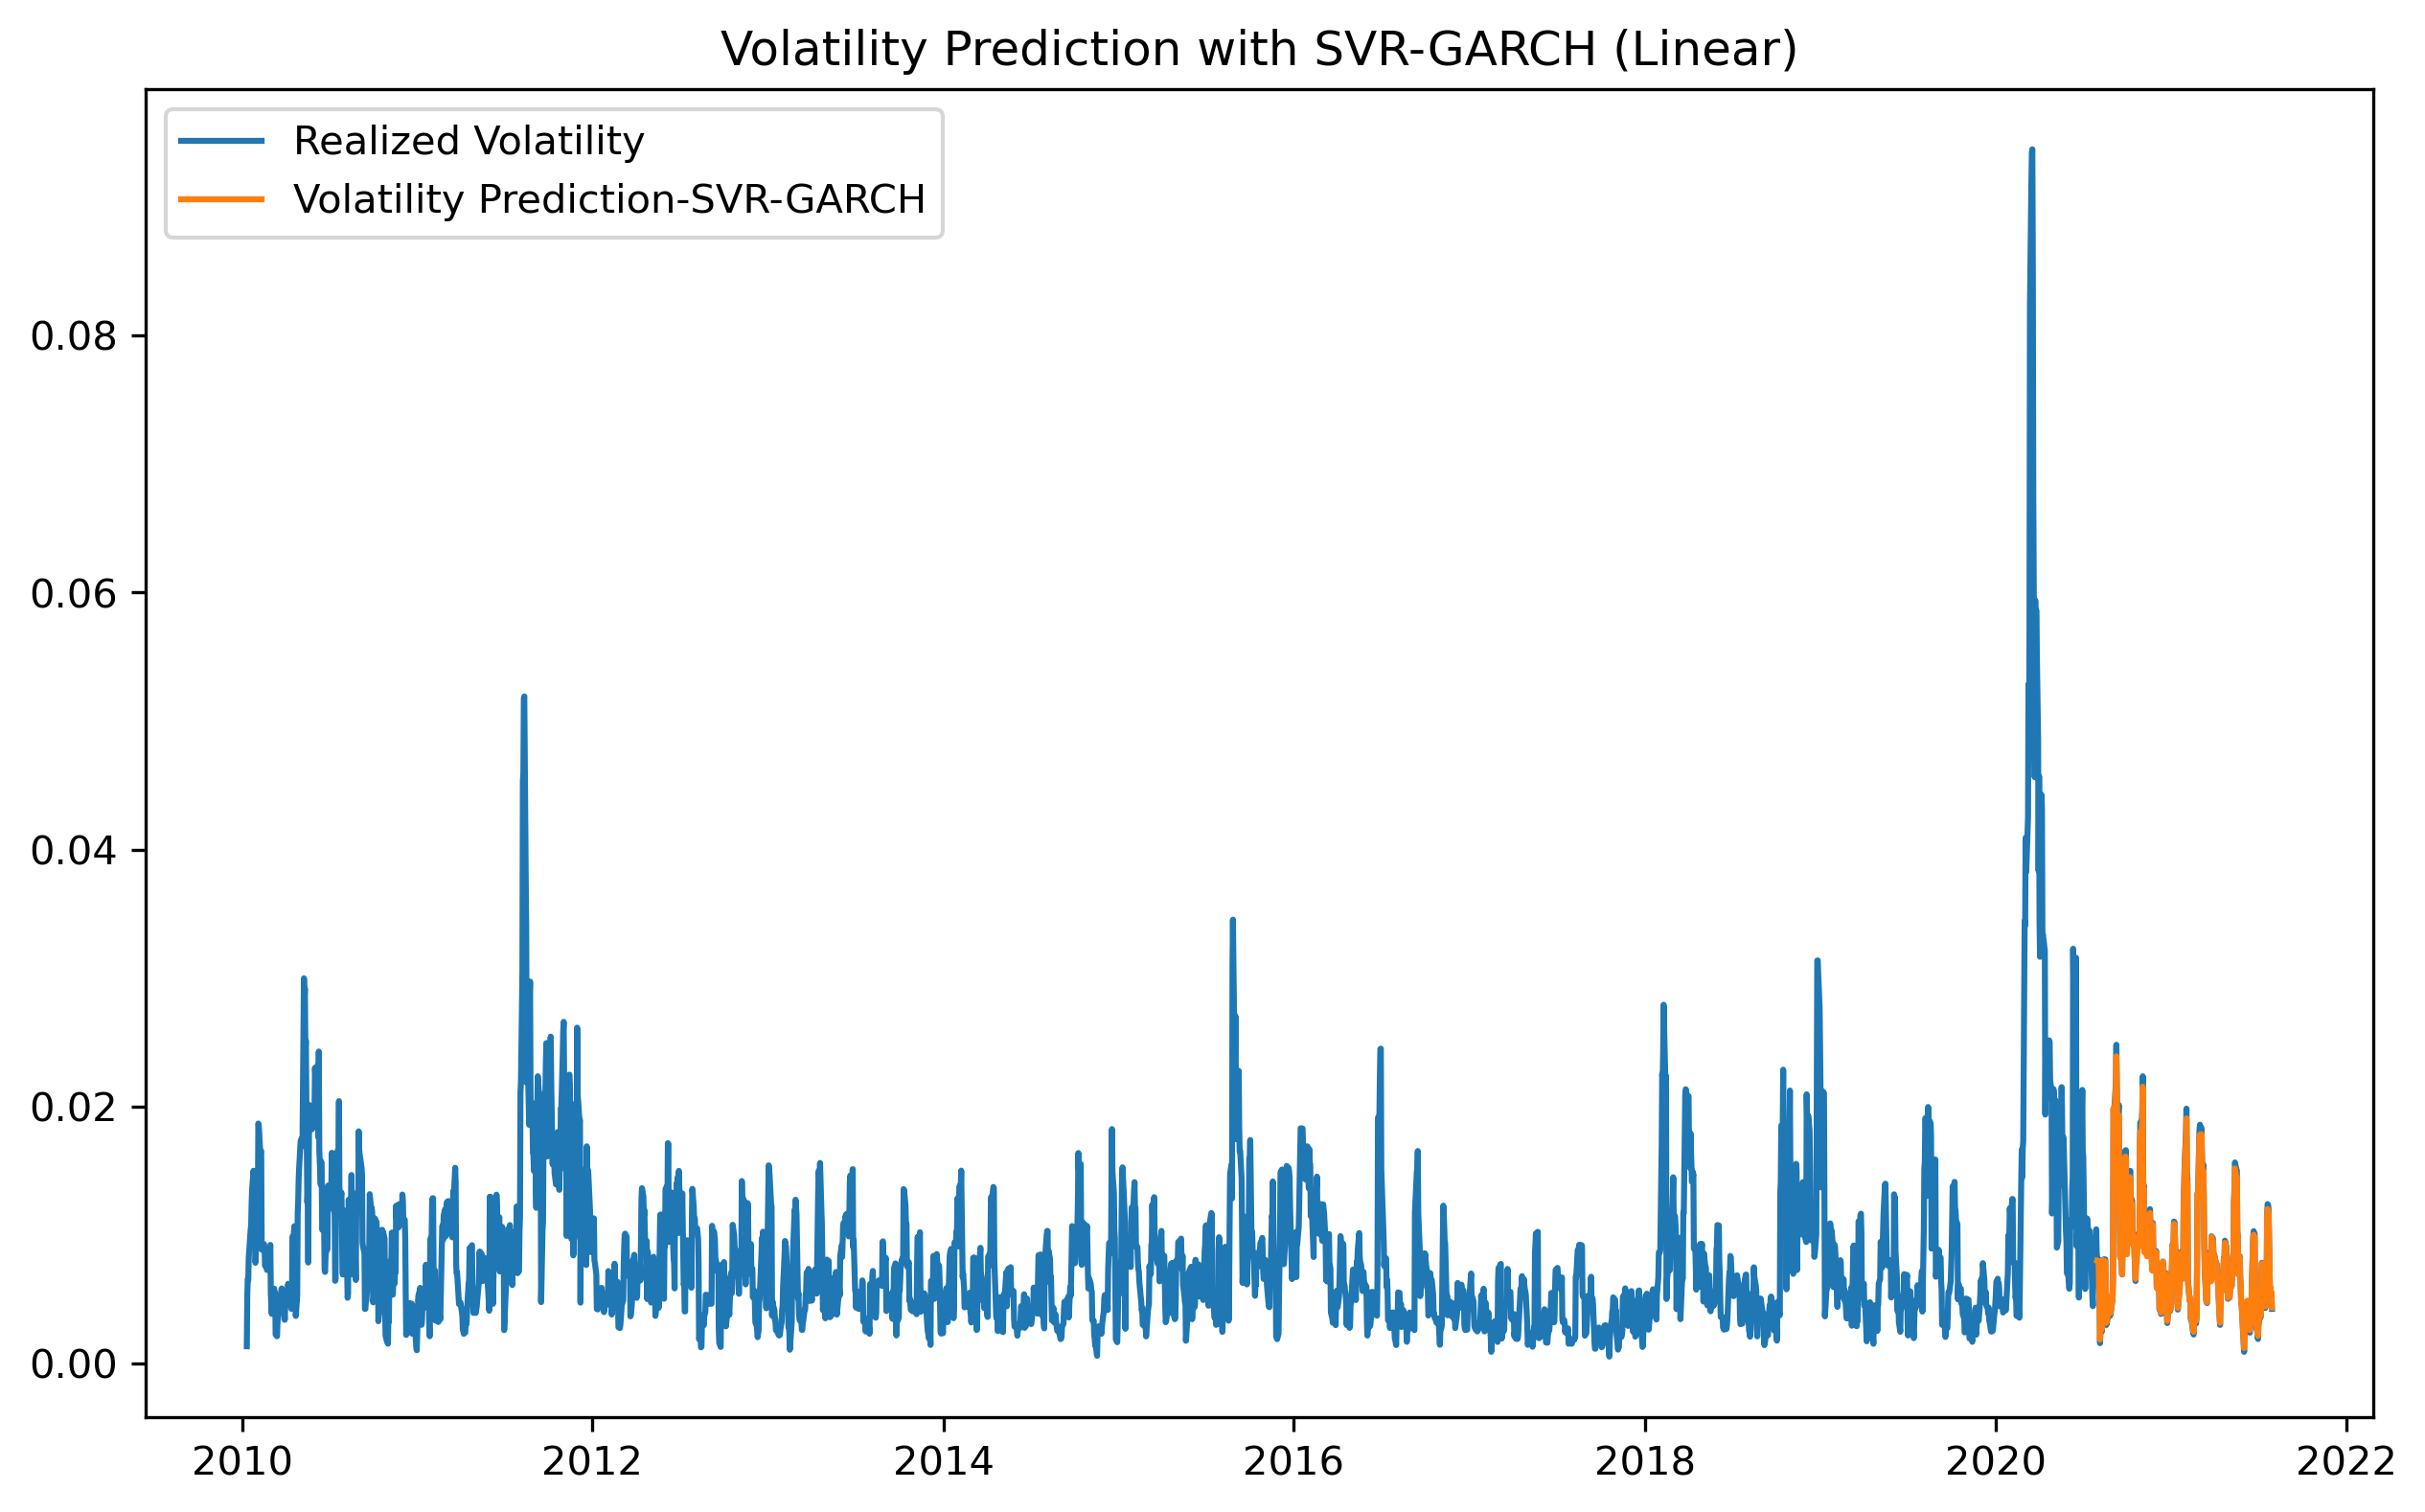

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

### SVR-GARCH RBF

만일 데이터가 선형 초평면으로 분리가 불가능한 경우, 모델의 성능이 떨어지게 된다. 이 경우에는 다른 커널 함수를 사용해야 한다. 이 케이스에서는 RBF(방사형 기저함수, 가우시안) 커널을 사용하였다.

In [51]:
para_grid ={'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

In [52]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [53]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                           predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'
      .format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.000967


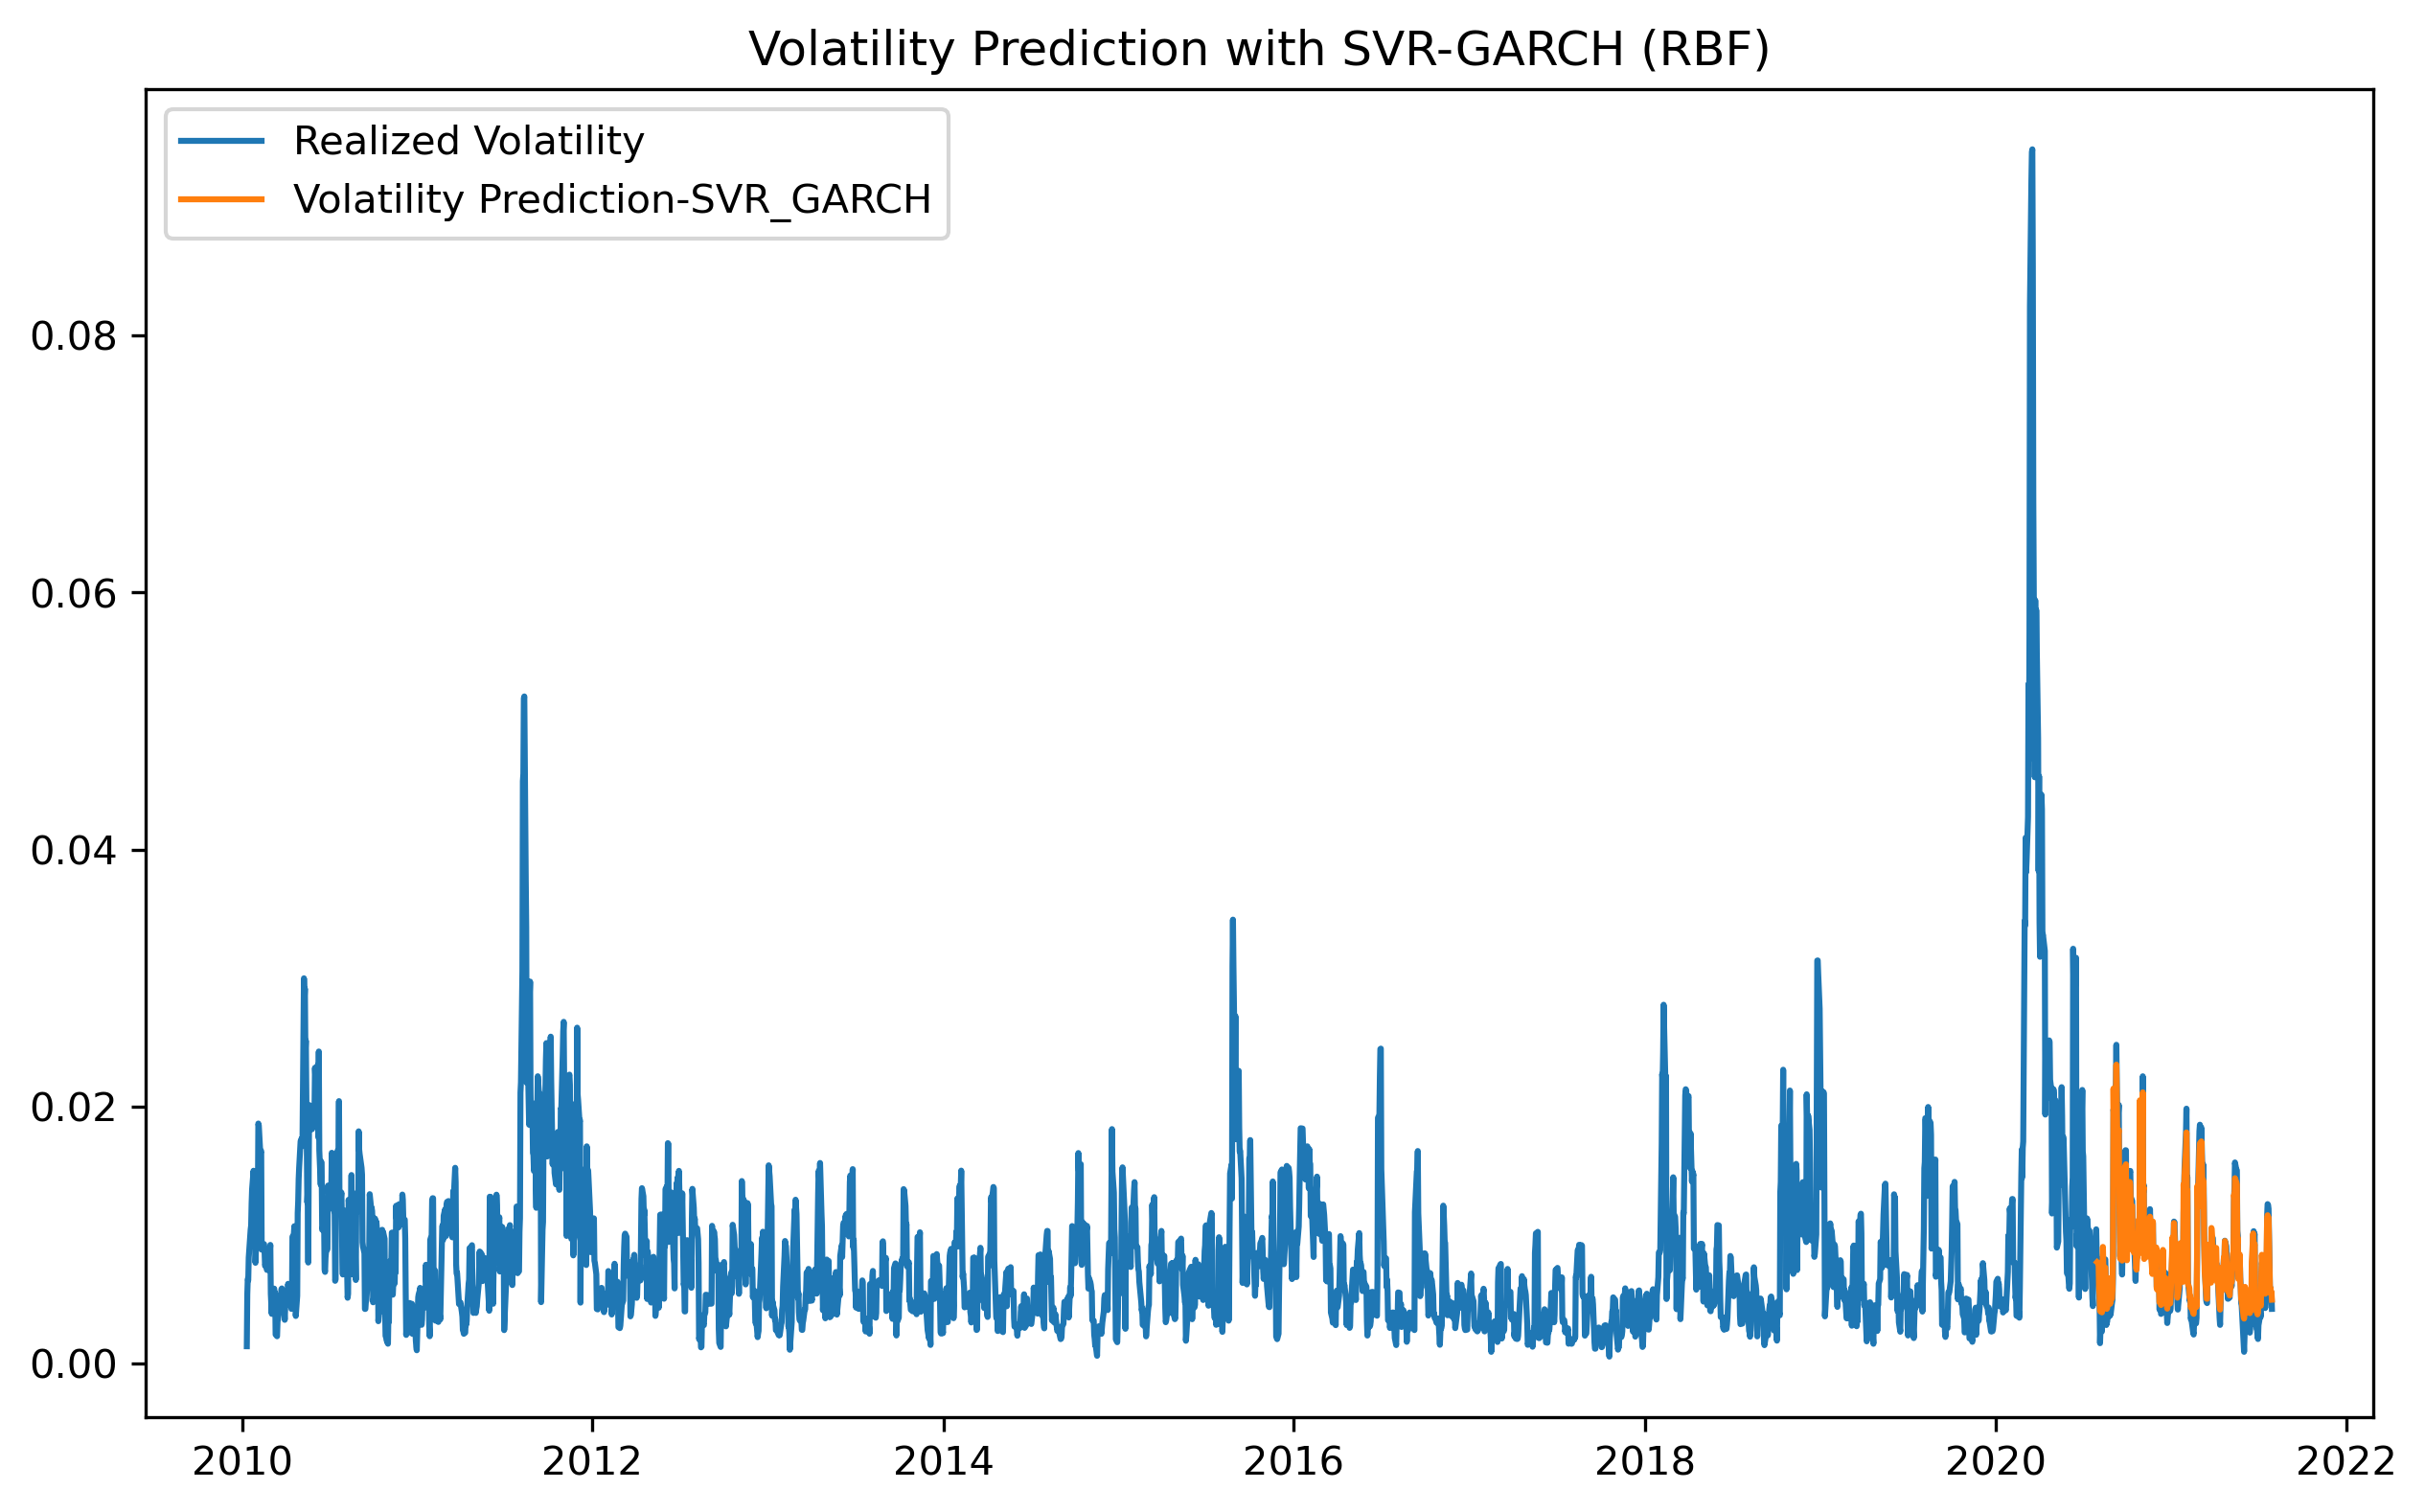

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

### SVR-GARCH Polynomial

마지막으로는 다항 커널을 이용하여 모델을 구축하였다.

In [55]:
para_grid = {'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

In [56]:
predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index

In [57]:
rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'\
      .format(rmse_svr_poly))

The RMSE value of SVR with Polynomial Kernel is 0.002561


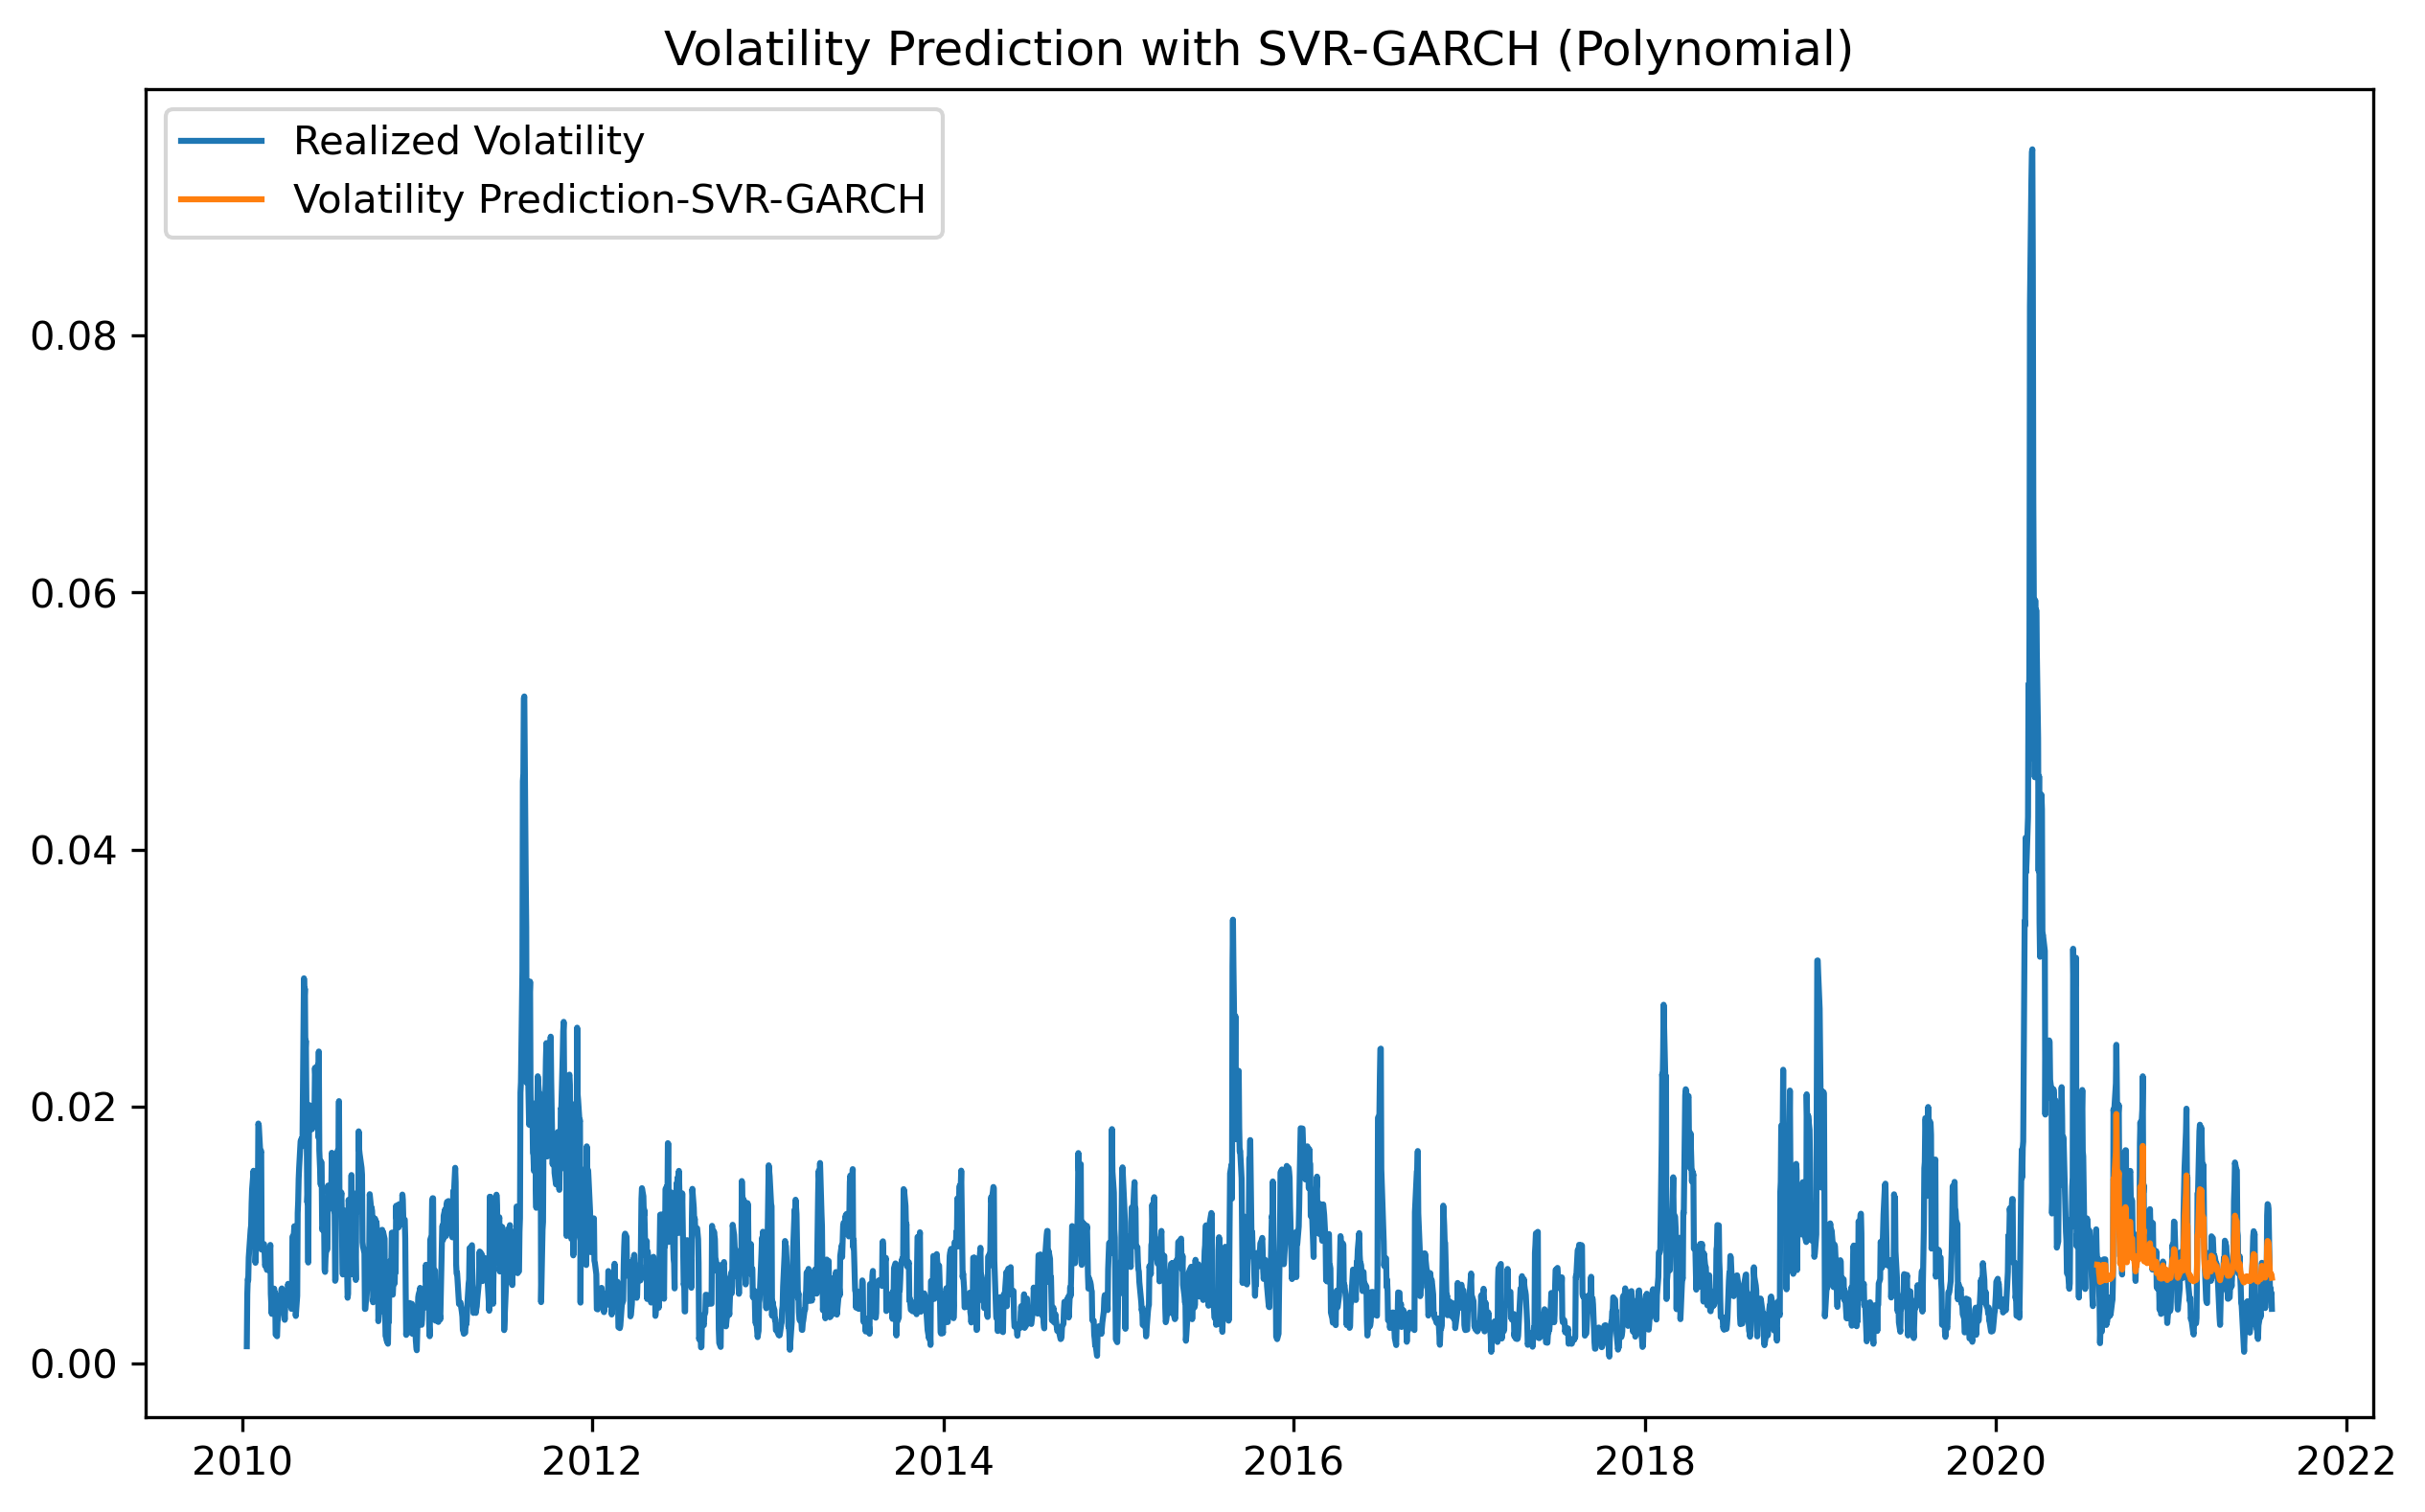

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)',
          fontsize=12)
plt.legend()
plt.show()

## NN-GARCH

다음은 신경망을 이용해 변동성을 모델링하는 과정이다. 신경망은 딥러닝을 구성하는 블록이다. Neural Network에서는 계수(Coefficient)보다는 가중치(Weights)로 더 많이 통용된다. 추정하는 가중치 parameter는 결국 선형모형에서 Coefficient를 추정하는것과 같다.

활성화 함수(Activation Function) 는 통계학에서의 연결 함수의 개념을 차용한 것이다.

대표적인 연결 함수로는 log, sigmoid, logistic이 존재하는데, 이중 sigmoid와 logistic은 초창기 Neural Network model의 활성화 함수로 사용된 것이다

신경망에는 일반적으로 세 가지 유형의 계층이 존재한다.

- 입력 계층

- 은닉 계층

- 출력 계층

#### 입력 계층(Input Layers)

입력계층에서는 데이터의 특성들이 입력된다. 입력 벡터 $\mathbf{x} = [x_1, x_2, ..., x_n]$는 특성 공간에서의 값들을 나타낸다. 입력값 $x_i$는 첫 번째 은닉계층으로 전달된다.

$$\mathbf{x} = [x_1, x_2, ..., x_n]$$

#### 은닉 계층(Hidden Layer)

은닉계층은 입력값에 가중치(weight)를 곱하고, 그 결과에 **편향(bias)** 을 더한 후 **활성화 함수(activation function)** 를 적용하여 비선형성을 도입한다.

입력 벡터 $\mathbf{x}$가 은닉계층으로 전달되며, 가중치 행렬 $\mathbf{W}^{(1)}$와 곱해진다. 이 때, $\mathbf{W}^{(1)}$는 입력계층에서 은닉계층으로의 가중치 행렬이다. 각 은닉층 노드 $h_j$에서의 계산은 다음과 같다.

$$h_j = f\left( \sum_{i=1}^{n} W_{ji}^{(1)} x_i + b_j^{(1)} \right)$$

여기서 $W_{ji}^{(1)}$는 입력 $x_i$에서 은닉층 뉴런 $h_j$로 가는 가중치, $b_j^{(1)}$는 은닉층 뉴런 $h_j$의 bias(y intercept)이며, $f$는 비선형 활성화 함수(ex. sigmoid, ReLU 등)이다. 통계학에서 활성화함수는 대개 연결 함수를 의미한다. 따라서 은닉층의 출력 벡터 $\mathbf{h}^{(1)}$는 다음과 같다.

$$\mathbf{h}^{(1)} = f\left( \mathbf{W}^{(1)} \mathbf{x} + \mathbf{b}^{(1)} \right)$$

여기서 $\mathbf{W}^{(1)}$는 은닉층의 가중치 행렬, $\mathbf{b}^{(1)}$는 은닉층의 편향 벡터이다.

#### 출력 계층(Output Layer)

출력층도 은닉층과 동일하게 가중치와 편향을 사용하여 계산된다. 은닉층에서 계산된 값들을 출력층으로 전달하여 최종 예측을 생성한다.

은닉층의 출력값 $\mathbf{h}^{(1)}$는 출력층으로 전달된다. 출력층에서 각 출력 노드 $y_k$에 대한 계산은 다음과 같다

$$y_k = f\left( \sum_{j=1}^{m} W_{kj}^{(2)} h_j^{(1)} + b_k^{(2)} \right)$$

여기서 $W_{kj}^{(2)}$는 은닉층 노드 $h_j^{(1)}$에서 출력층 노드 $y_k$로 가는 가중치, $b_k^{(2)}$는 출력층 노드 $y_k$의 bias이고 $f$는 출력층에서 사용하는 활성화 함수이다. 출력층에서의 출력 벡터 $\mathbf{y}$는 다음과 같이 표현된다

$$\mathbf{y} = f\left( \mathbf{W}^{(2)} \mathbf{h}^{(1)} + \mathbf{b}^{(2)} \right)$$

여기서 $\mathbf{W}^{(2)}$는 출력층의 가중치 행렬, $\mathbf{b}^{(2)}$는 출력층의 편향 벡터이다

다음은 신경망 구조를 도식화 한 그림이다.

<center>
    
<img src="./Image/neural.png" width="700px" height="400px">
    
</center>

신경망 알고리즘에서는 비용함수 최소화를 위해 역전파(backpropagation)을 사용한다. 역전파의 아이디어는 실제 값과 예측값 사이의 오차를 계산한 후 이를 은닉층으로 전달하는 것을 의미한다. 즉 학습과 반대 방향으로 오차가 전파된다. 이는 미분의 chain rule과 유사한 과정을 통해 진행된다.

<center>
    
<img src="./Image/역전파.jpg" width="700px" height="400px">
    
</center>

In [59]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1) 
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
               'max_iter': [500, 1000],
               'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])

In [60]:
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

In [61]:
rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                      NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

The RMSE value of NN is 0.000647


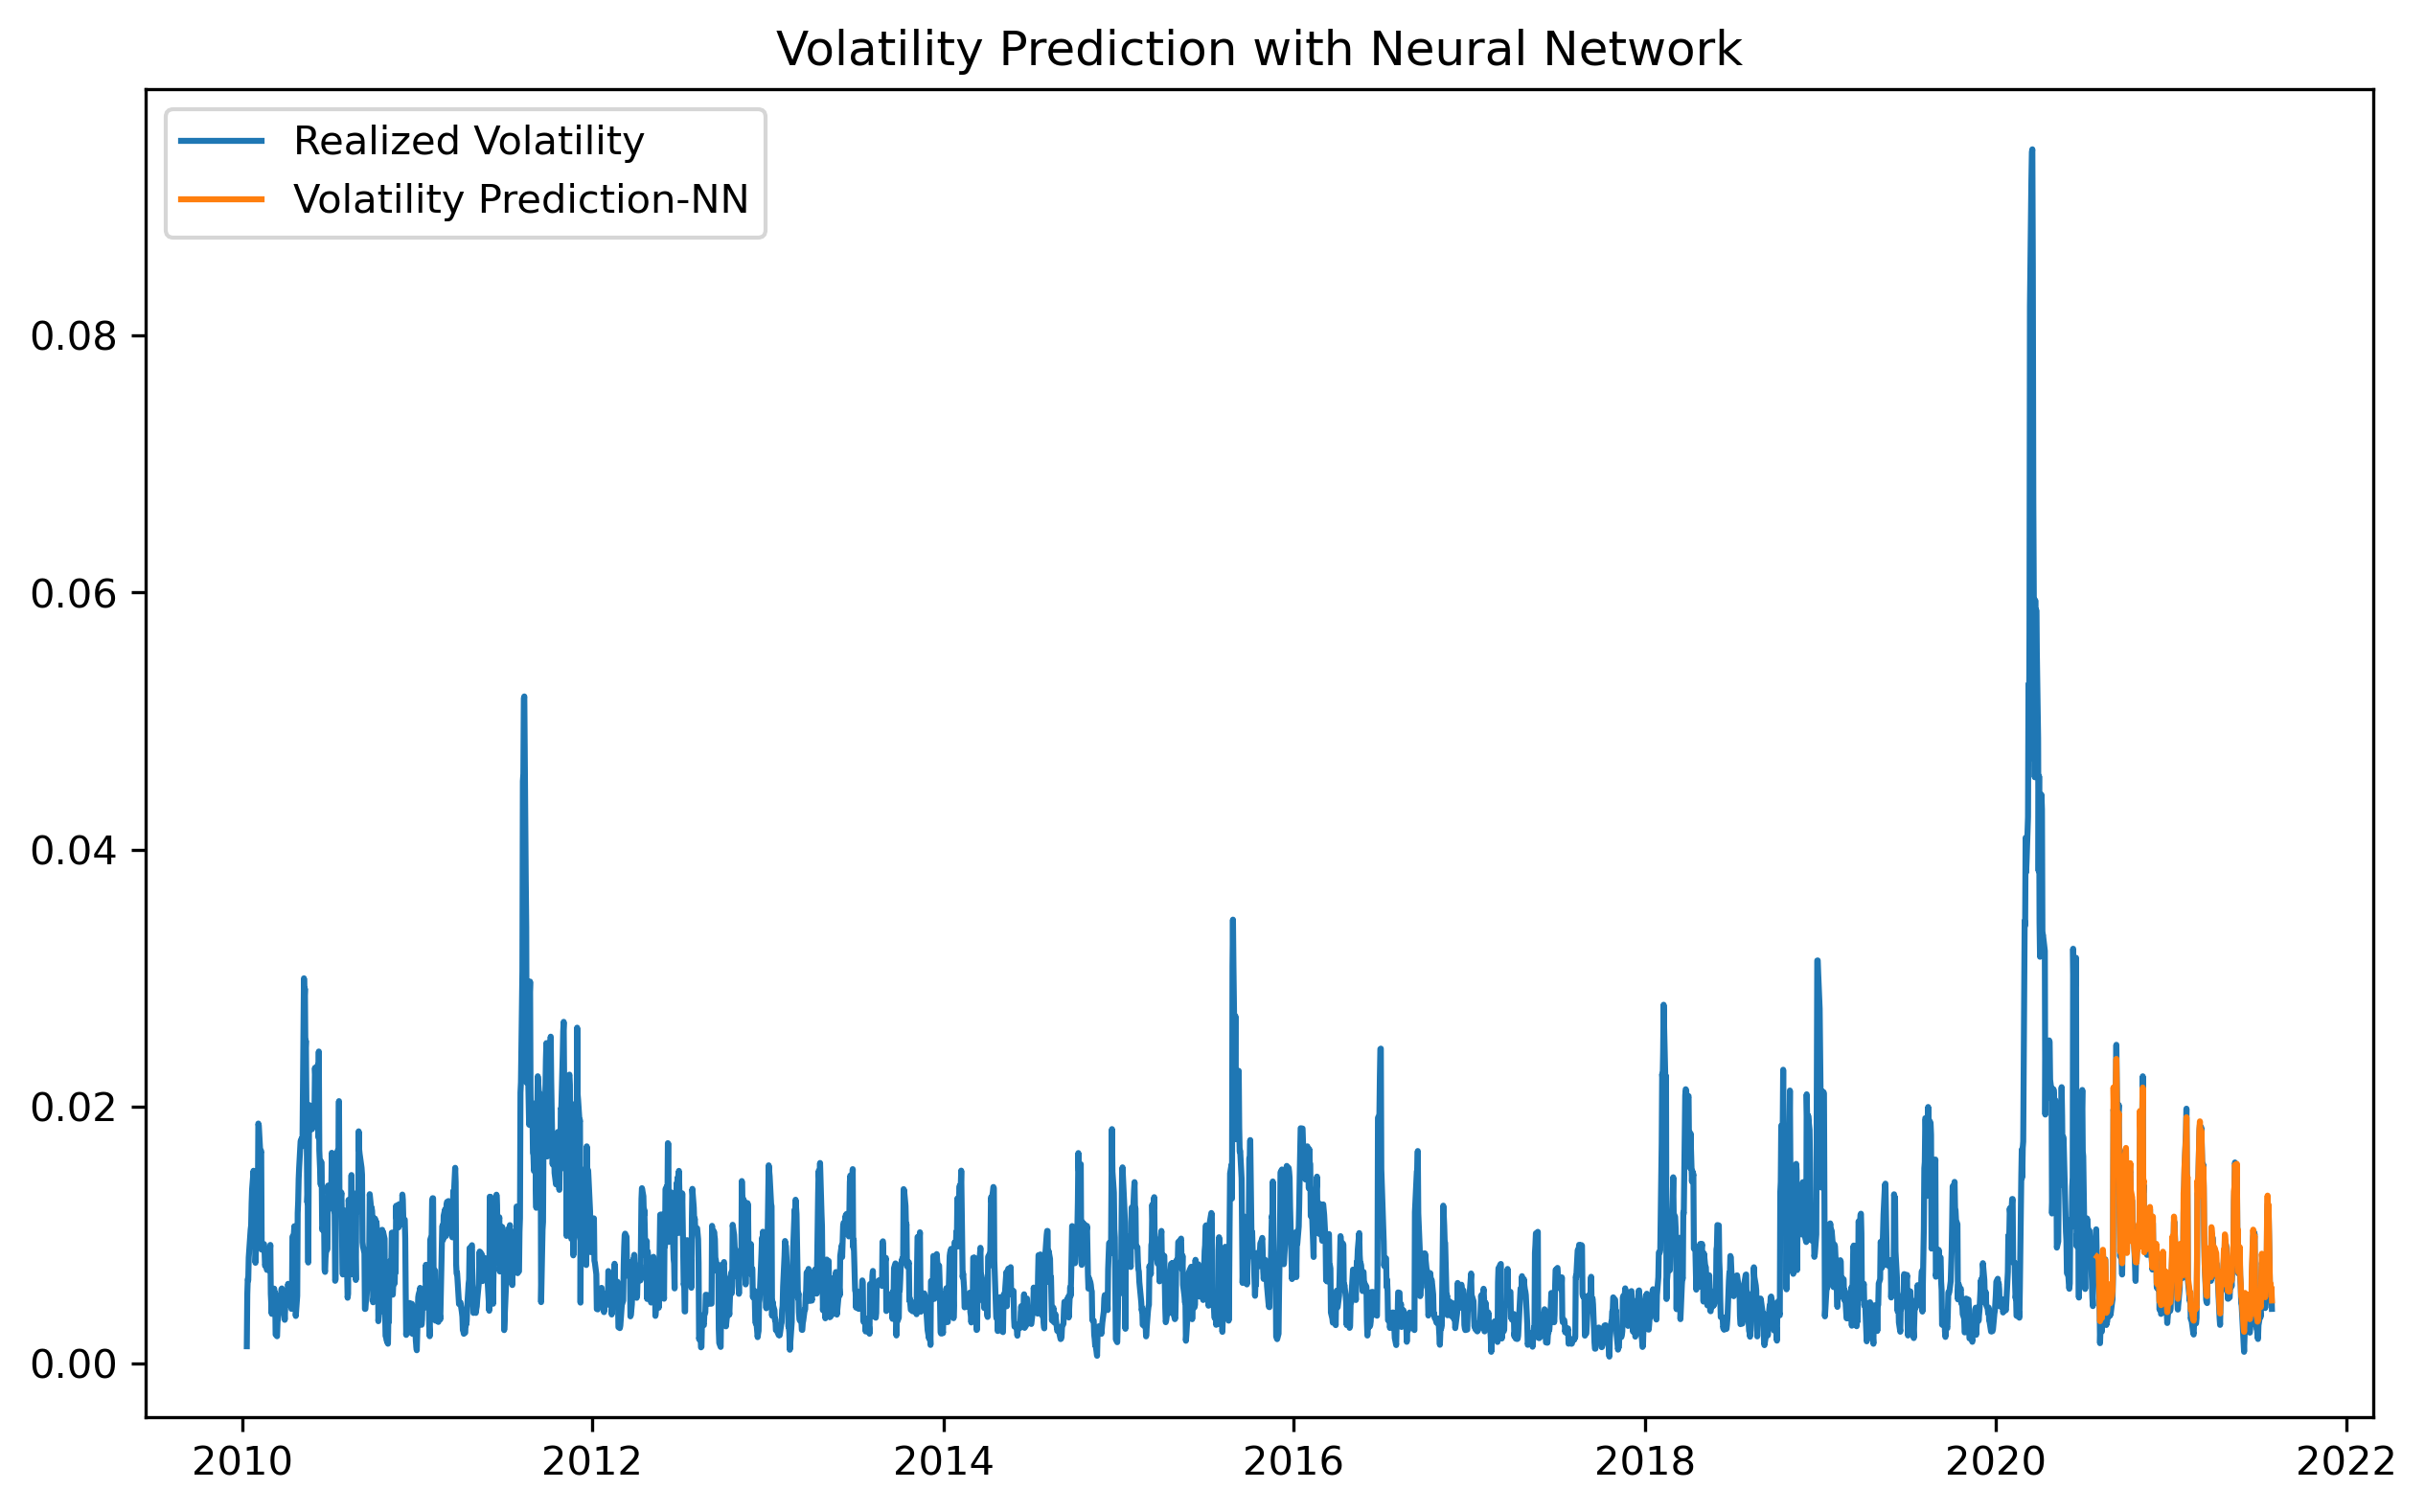

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

## DL-GARCH

다음은 딥러닝을 이용해 변동성을 예측하는 과정이다. keras를 사용해 은닉층 구조를 쉽게 만들 수 있다. 

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [64]:
model = keras.Sequential(
    [layers.Dense(256, activation="relu"),
     layers.Dense(128, activation="relu"),
     layers.Dense(1, activation="linear"),])

In [65]:
model.compile(loss='mse', optimizer='rmsprop')

In [66]:
epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
DL_RMSE_1:0.000624
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
DL_RMSE_2:0.000855
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
DL_RMSE_3:0.000691
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
DL_RMSE_4:0.000684


In [67]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index

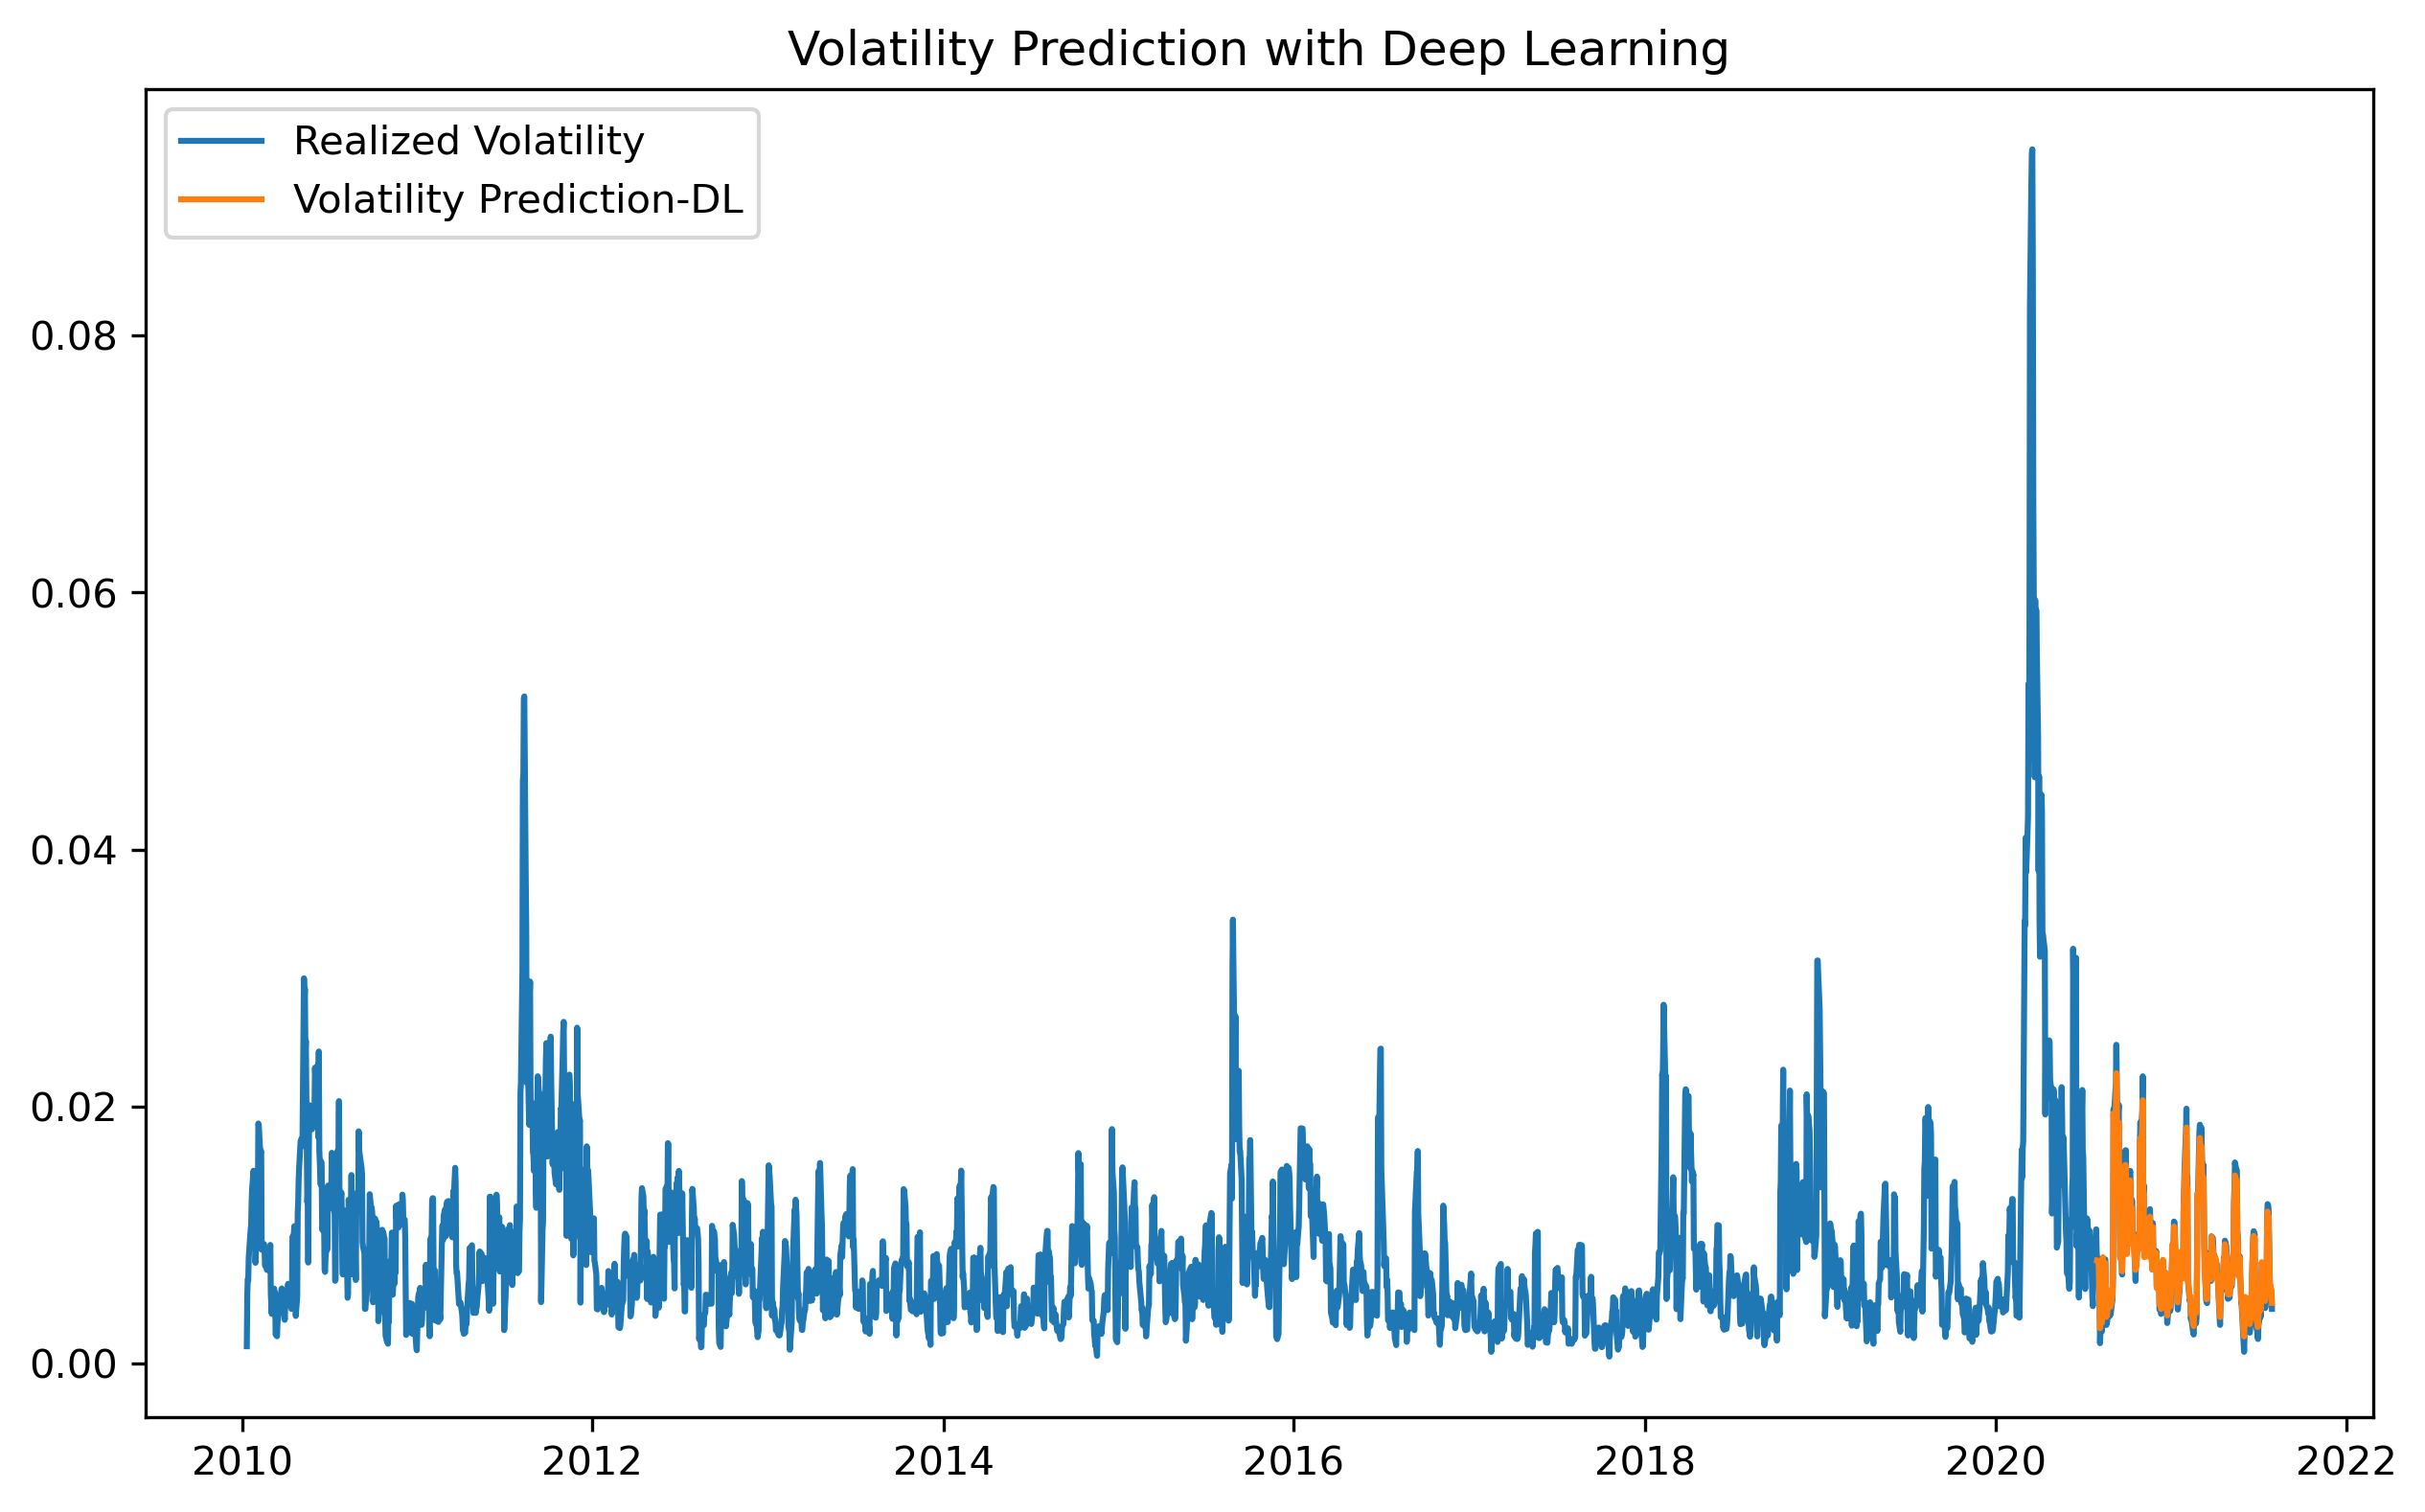

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()

## Bayesian Approach

베이즈 접근 방법은 확률 분포를 불확실한 것으로 간주하고 새로운 정보가 들어오면 기존 정보와 결합하여 확률 분포에 대한 새로운 기대를 산출한다. 더 자세히 서술하자면, 베이즈 접근 방식은 조건부 분포를 기반으로 하며 확률은 불확실한 이벤트에 대한 정도를 측정한다. 따라서 베이즈 정리는 새로운 정보를 기반으로 기존 기대를 갱신하는데 사용할 수 있는 규칙을 제공한다.

### 베이즈 정리

조건부확률을 구하는 다음 공식을 베이즈 정리(Bayesian rule)라고 한다.

$$ 
P(A|B) = \dfrac{P(B|A)P(A)}{P(B)} 
$$

여기에서 $P(A)$는 사전확률(prior)이라고 하며 사건 B가 발생하기 전에 가지고 있던 사건 A의 확률이다. 만약 사건 B가 발생하면 이 정보를 반영하여 사건 $A$의 확률은 $P(A|B)$라는 값으로 변하게 되며 이를 사후확률(posterior)이라고 한다.

사후확률값은 사전확률에 $\dfrac{P(B|A)}{P(B)}$라는 값을 곱하면 얻을 수 있다. 곱하는 $P(B|A)$는 가능도(likelihood)라고 하고 나누는 $P(B)$는 *규화 상수(normalizing constant) 혹은 증거(evidence)라고 한다.

$$
P(A|B) = \dfrac{P(B|A)P(A)}{P(B)}
$$

* $P(A|B)$: 사후확률(posterior). 사건 B가 발생한 후 갱신된 사건 A의 확률
* $P(A)$: 사전확률(prior). 사건 B가 발생하기 전에 가지고 있던 사건 A의 확률
* $P(B|A)$: 가능도(likelihood). 사건 A가 발생한 경우 사건 B의 확률
* $P(B)$: 정규화 상수(normalizing constant) 또는 증거(evidence). 확률의 크기 조정

### 베이즈 추정법

베이즈 정리를 응용한 베이즈 추정법은 주어진 데이터 $\{x_{1},\ldots,x_{N}\}$를 기반으로 모수 $\mu$의 조건부 확률분포 $p(\mu \vert x_{1},\ldots,x_{N})$를 계산하는 작업이다. 조건부 확률분포를 구하므로 베이즈 정리를 사용한다.

$$

p(\mu \mid x_{1},\ldots,x_{N}) = \dfrac{p(x_{1},\ldots,x_{N} \mid \mu) \cdot p(\mu)}{p(x_{1},\ldots,x_{N})} \propto p(x_{1},\ldots,x_{N}  \mid \mu )  \cdot p(\mu)

$$ 


* $p(\mu)$는 **모수의 사전(Prior)분포**다. 사전 분포는 베이지안 추정 작업을 하기 전에 이미 알고 있던 모수 $\mu$의 분포를 뜻한다. 
모수의 분포에 대해 아무런 지식이 없는 경우에는 균일(uniform) 분포 $\text{Beta}(1,1)$나 0을 중심으로 가지는 정규분포 $\mathcal{N}(0,\sigma_0^2)$ 등의 무정보분포(non-informative distribution)를 사용할 수 있다. 

* $p(\mu \mid x_{1},\ldots,x_{N})$는 **모수의 사후(Posterior)분포**다. 수학적으로는 데이터 $x_{1},\ldots,x_{N}$가 주어진 상태에서의 $\mu$에 대한 조건부 확률 분포다. 우리가 베이즈 추정법 작업을 통해 구하고자 하는 것이 바로 이 사후 분포다. 
 
* $p(x_{1},\ldots,x_{N} \mid \mu)$는 **가능도(likelihood)분포**다. 모수 $\mu$가 특정한 값으로 주어졌을 때 주어진 데이터 $\{x_{1},\ldots,x_{N}\}$가 나올 수 있는 확률값을 나타낸다.

## 마르코프 체인 몬테 카를로

1차 마르코프 체인은 다음과 같은 마코프(Markov) 특성을 가지는 이산시간 확률 프로세스를 말한다.

$$
P(C_{t+1} \mid C_t, \cdots, C_1) = P(C_{t+1} \mid C_t)
$$

즉, 현재 상태의 확률이 가장 최근의 상태에만 종속되는 경우를 모델링 한 체인이 1차 마르코프 체인이다. 

이 때 특정 시간 $t$ 동안 특정한 한 상태 $i$ 에서 특정한 다른 상태 $j$ 로 전이할 확률을 전이 확률(Transition Probability) 이라고 한다.

$$
\gamma_{ij}(t) = P(C_{s+t}=j|C_{s}=i) 
$$


또한 모든 상태 조합에 대한 전이 확률을 나타낸 것이 전이 확률 행렬(Transition Probability Matirx)이다.

$$
\Gamma(t) = \{ \gamma_{ij}(t) \}, \;\;\; \Gamma = \Gamma(1)



이 경우 마르코프 체인 몬테카를로는 마르코프 체인으로 사후 확률이 가장 높은 매개변수 공간 $\theta$를 찾는다. 표본 크기가 증가함에 따라 매개변수값은 사후 밀도에 가까워진다. 
$$\lim_{j \to +\infty} \theta^j \rightarrow^D Pr(\theta \vert x)$$

여기서 $D$는 분포 근사를 나타낸다. 이 방법론을 이용해 매개변수 공간의 실현값을 사용해 사후 분포를 추론할 수 있다. 간단히 말하자면 마르코프 체인 몬테카를로는 사후 확률을 계산할 수 있도록 사후 밀도에서 IID 샘플을 수집하게 해준다.

In [69]:
import quantecon as qe
from quantecon import MarkovChain
import networkx as nx
from pprint import pprint 

In [70]:
# P는 전이 행렬을 의미함
P = [[0.5, 0.2, 0.3],
     [0.2, 0.3, 0.5],
     [0.2, 0.2, 0.6]]  

mc = qe.MarkovChain(P, ('studying', 'travelling', 'sleeping'))  # 마르코프 체인을 구현하는 코드
mc.is_irreducible

True

In [71]:
states = ['studying', 'travelling', 'sleeping']
initial_probs = [0.5, 0.3, 0.6]
state_space = pd.Series(initial_probs, index=states, name='states')

In [72]:
q_df = pd.DataFrame(columns=states, index=states)
q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.5, 0.2, 0.3]
q_df.loc[states[1]] = [0.2, 0.3, 0.5]
q_df.loc[states[2]] = [0.2, 0.2, 0.6]

In [73]:
def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges
edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

{('sleeping', 'sleeping'): 0.6,
 ('sleeping', 'studying'): 0.2,
 ('sleeping', 'travelling'): 0.2,
 ('studying', 'sleeping'): 0.3,
 ('studying', 'studying'): 0.5,
 ('studying', 'travelling'): 0.2,
 ('travelling', 'sleeping'): 0.5,
 ('travelling', 'studying'): 0.2,
 ('travelling', 'travelling'): 0.3}


In [74]:
G = nx.MultiDiGraph()
G.add_nodes_from(states)
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)
edge_labels = {(n1, n2):d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'mc_states.dot')

FileNotFoundError: [WinError 2] "dot" not found in path.

### 메트로폴리스-헤이스팅스

메트로폴리스-헤이스팅스 기법(이하 MH)을 사용하면 샘플링을 두 단계로 효율적으로 수행할 수 있다. 먼저 제시된 밀도에서 샘플을 추출한 후 수락 혹은 기각을 결정한다. $q(\theta \vert \theta_{t-1})$을 제안된 밀도라고 하고 $\theta$를 매개변수 공간이라고 하자. 우리가 표본을 생성하고자 하는 대상 확률 분포인 타겟 분포를 $p(x)$라 하면 MH의 전체 알고리즘은 다음과 같다.

1. 매개변수 공간 $\theta$에서 $\theta^1$의 초기값을 선택한다.

2. 제안 밀도에서 새 매개변수값 $\theta^2$를 선택한다. 편의상 가우스 분포나 균일 분포를 택한다.

3. 다음 수락 확률을 계산한다.
$$Pr_a(\theta^*, \theta^{t-1})=min(1, \frac{p(\theta^*)/q(\theta^* \vert \theta^{t-1})}{p(\theta^{t-1})/q(\theta^{t-1}\vert \theta^*)})$$

4. $Pr_a(\theta^*, \theta^{t-1})$가 $U(0,1)$의 균등분포에서 추출한 표본 값보다 클 경우 2단계부터 이 과정을 반복한다.

다음은 PYFLUX 라이브러리를 이용해 이를 적용한 코드이다.


In [79]:
import ctypes
import pyflux as pf
from scipy.stats import kurtosis

ImportError: No module named 'pyflux.__check_build._check_build'
___________________________________________________________________________
Contents of e:\학교과제\서강대학교\quantify 학회\3기\시니어 학습\팀 세션\ch04_machinelearning&volatility\pyflux\__check_build:
setup.py                  _check_build.c            __init__.py
__pycache__
___________________________________________________________________________
It seems that the pyflux has not been built correctly.
If you have installed pyflux from source, please do not forget
to build the package before using it: run `python setup.py install`
in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.


In [ ]:
model = pf.GARCH(ret.values, p=1, q=1)
print(model.latent_variables)
model.adjust_prior(1, pf.Normal())
model.adjust_prior(2, pf.Normal())
x = model.fit(method='M-H', iterations='1000')
print(x.summary())

In [ ]:
model.plot_z([1, 2])
model.plot_fit(figsize=(15, 5))
model.plot_ppc(T=kurtosis, nsims=1000)

In [ ]:
bayesian_prediction = model.predict_is(n, fit_method='M-H')

In [ ]:
bayesian_RMSE = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                         bayesian_prediction.values / 100))
print('The RMSE of Bayesian model is {:.6f}'.format(bayesian_RMSE))

In [ ]:
bayesian_prediction.index = ret.iloc[-n:].index

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,
         label='Realized Volatility')
plt.plot(bayesian_prediction['Series'] / 100,
         label='Volatility Prediction-Bayesian')
plt.title('Volatility Prediction with M-H Approach', fontsize=12)
plt.legend()
plt.show()